__03.09.03 Course Project 3__<br>
__Dominik Heeb, August 2021__

# House Prices

In [ ]:
# diagrams:
# many diagrams consume substantial performance
# the 'Show Diagrams' flag saves time when restarting kernel during development when set to False
# productive: True
# development: False
gcblnShowDiagrams = True 

## Getting the raw data

In [2]:
import pandas as pd

# remark on missing values:
# - replacing the string NA by the Numpy NaN could have done here
# - however, this will be done later, within the data-cleaning process
strFilenameTrain = "house-prices.csv"
strFilenameTest = "house-prices-test.csv"
dfrRawTrainData = pd.read_csv(strFilenameTrain)
dfrRawTestData = pd.read_csv(strFilenameTest)
print("Shapes train vs. test data set:", dfrRawTrainData.shape, dfrRawTestData.shape)

Shapes train vs. test data set: (2430, 82) (500, 81)


In [3]:
dfrRawTrainData.head(2)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000


In [4]:
dfrRawTestData.head(2)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
0,2217,909279080,50,RL,NaN,11275,Pave,NaN,IR1,HLS,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
1,837,907126050,20,RL,65.0,9757,Pave,NaN,Reg,Low,...,92,0,NaN,NaN,NaN,0,10,2009,WD,Normal


__Observations:__
* The shapes of the train data set and the test data set are as expected.
* The target column is `SalePrice`.
* The test data does not have a SalePrice column containing `NaN`, but lacks this column entirely.

## Exploratory data analysis (EDA)

### General

__Detailed data description:__
* `documentation.txt` (12 p.)
* `https://ww2.amstat.org/publications/jse/v19n3/decock.pdf` (15 p.).

### EDA for Target

__Definition:__
* The target variable is `SalePrice`.
* Prices are given in USD ($).

__Initial considerations:__
* Many variables that are limited by 0 on the left-hand side, but open end to the right-hand side have a __skewed distribution__.
* Often such distribution can be transformed into normal or at least symmetrical distributions by __log transformations__.
* Thus, the both the raw and the log-transformed distribution shall be checked by __visual inspection__.
* I choose __log<sub>10</sub>__ because to me it is more intuitive than the natural logarithm.
* I add a formal __Shapiro-Wilk test__ for normality.

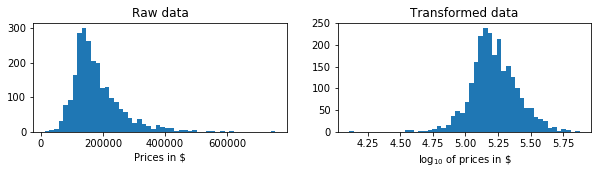

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# distribution plots
srsSalePrice = dfrRawTrainData["SalePrice"]
if gcblnShowDiagrams:
    intBins = 50
    fltFigureWidth = 10
    fltFigureHeight = 2
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(fltFigureWidth, fltFigureHeight))
    ax1.hist(srsSalePrice, bins=intBins)
    ax2.hist(np.log10(srsSalePrice), bins=intBins)
    ax1.set_title("Raw data")
    ax2.set_title("Transformed data")
    ax1.set_xlabel("Prices in $")
    ax2.set_xlabel("log$_{10}$ of prices in \$")
    plt.show()

In [6]:
from scipy import stats
print("Shapiro-Wilk test results (normality):".upper())
for strType in ["Raw", "Transformed"]:
    if strType == "Raw":
        afltValues = srsSalePrice.values
    else:
        afltValues = np.log10(srsSalePrice.values)
    fltTestStatisticW, fltPValue= stats.shapiro(afltValues)
    print(f"{strType} data: ".ljust(18), "W={:.3f}".format(fltTestStatisticW), ", P={:.3E}".format(fltPValue), " N={:.0f}.".format(srsSalePrice.shape[0]),  sep="")

SHAPIRO-WILK TEST RESULTS (NORMALITY):
Raw data:         W=0.875, P=1.764E-40 N=2430.
Transformed data: W=0.985, P=1.591E-15 N=2430.


__Conclusions:__
* Visual inspection shows a __skewed distribution__ for the raw data.
* The __log<sub>10</sub>__  transformation yields a symmetrical, more or less normal distribution.
* __Formal Shapiro-Wilk tests__ yield significant deviations from a normal distribution, both for the raw and the transformed data.
* Despite the significant deviation indicated by Shapiro Wilk test for the transformed data (P<0.001) I'll consider the __transformation__ as __good enough__ for the purposes of the analysis to follow. 
* I apply the __log<sub>10</sub>__ transformation.
* The transformed column is `LogPrice`.

In [7]:
# just copy test data for analogy, without transformation
dfrLogTestData = dfrRawTestData.copy()

# apply log10 to SalePrice
dfrLogTrainData = dfrRawTrainData.copy()
dfrLogTrainData["LogPrice"] = np.log10(dfrLogTrainData.SalePrice)
dfrLogTrainData.head(2)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,LogPrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,4,2009,WD,Normal,236000,5.372912
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,6,2006,WD,Normal,155000,5.190332


### EDA for features

__Data levels:__
* The data levels of the features are given in the documentation `documentation.txt`.
* In a first step, I will run EDA for all features within a given data level in a similar way.
* The data levels are defined as follows:

In [8]:
# group features into data levels
# according to documentation.txt
strIdentifiers ="Order,PID"
strNominal ="MS SubClass,MS Zoning,Street,Alley,Land Contour,Lot Config,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Foundation,Heating,Central Air,Garage Type,Misc Feature,Sale Type,Sale Condition"
strOrdinal ="Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence"
strDiscrete ="Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Mo Sold,Yr Sold"
strContinuous ="Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val"

# convert to lists
lstrIdentifiers = strIdentifiers.split(",")
lstrNominal     = strNominal.split(",")
lstrOrdinal     = strOrdinal.split(",")
lstrDiscrete    = strDiscrete.split(",")
lstrContinuous  = strContinuous.split(",")

lstrAllFeatures = lstrIdentifiers + lstrNominal + lstrOrdinal + lstrDiscrete  + lstrContinuous
print("Documentation:".ljust(18),2,23,23,14,20-1)
print("Check (incl. sum):".ljust(18), len(lstrIdentifiers),len(lstrNominal),len(lstrOrdinal),len(lstrDiscrete),len(lstrContinuous),len(lstrAllFeatures))

Documentation:     2 23 23 14 19
Check (incl. sum): 2 23 23 14 19 81


__Check identifiers__:
* The order does not contain any information relevant to the analysis, hence I drop it.
* PID stands for "parcel identifier", parcel here meaning 'plot of land'.
* The PID contains integer numbers with 9 or 10 digits (see below). 
* According to the documentation, the PID does not contain any hidden relevant information.
* As the PID will be used to create the final datasets to be uploaded in, I keep it.

In [9]:
# check PID
dfrLogTrainData.PID.describe().loc[['count','min','max']].astype(int)

count          2430
min       526301100
max      1007100110
Name: PID, dtype: int32

In [10]:
# prepare categoriy dictionary
dlstrCategories = {}

# check categories
def CompareCategories(dlstrExpected, dfrOccurring, lstrFeatures):
    for strNominal in lstrFeatures:
        afltCategoriesExpected = np.sort(dlstrExpected[strNominal])
        afltCategoriesOccurring= np.sort(dfrOccurring[strNominal].dropna().unique())
        if np.array_equal(afltCategoriesExpected,afltCategoriesOccurring):
            print(f"{strNominal}: OK")
        else:
            intLeftAdjust = 14
            print(f"{strNominal}: categories differ:")
            print("   EXPECTED:".ljust(intLeftAdjust), afltCategoriesExpected)
            print("   OCCURRING:".ljust(intLeftAdjust), afltCategoriesOccurring)

__Check nominal data__:

In [11]:
# define nominal categories
dlstrCategories["MS SubClass"] = ["20","30","40","45","50","60","70","75","80","85","90","120","150","160","180","190"] # stringes preferred
dlstrCategories["MS Zoning"] = ["A","C","FV","I","RH","RL","RP","RM"]
dlstrCategories["Street"] = ["Grvl","Pave"]
dlstrCategories["Alley"] = ["Grvl","Pave","NA"]
dlstrCategories["Land Contour"] = ["Lvl","Bnk","HLS","Low"]
dlstrCategories["Lot Config"] = ["Inside","Corner","CulDSac","FR2", "FR3"]
dlstrCategories["Neighborhood"] = ["Blmngtn","Blueste","BrDale","BrkSide","ClearCr","CollgCr","Crawfor","Edwards",
                                   "Gilbert","Greens","GrnHill","IDOTRR","Landmrk","MeadowV","Mitchel","Names","NoRidge",
                                   "NPkVill","NridgHt","NWAmes","OldTown","SWISU","Sawyer","SawyerW","Somerst","StoneBr",
                                   "Timber","Veenker"]
dlstrCategories["Condition 1"] = ["Artery","Feedr","Norm","RRNn","RRAn","PosN","PosA","RRNe","RRAe"]
dlstrCategories["Condition 2"] = dlstrCategories["Condition 1"].copy()
dlstrCategories["Bldg Type"] = ["1Fam","2FmCon","Duplx","TwnhsE","TwnhsI"]
dlstrCategories["House Style"] = ["1Story","1.5Fin","1.5Unf","2Story","2.5Fin","2.5Unf","SFoyer","SLvl"]
dlstrCategories["Roof Style"] = ["Flat","Gable","Gambrel","Hip","Mansard","Shed"]
dlstrCategories["Roof Matl"] = ["ClyTile","CompShg","Membran","Metal","Roll","Tar&Grv","WdShake","WdShngl"]
dlstrCategories["Exterior 1st"] = ["AsbShng","AsphShn","BrkComm","BrkFace","CBlock","CemntBd","HdBoard","ImStucc",
                                   "MetalSd","Other","Plywood","PreCast","Stone","Stucco","VinylSd","WdSdng","WdShing"]
dlstrCategories["Exterior 2nd"] = dlstrCategories["Exterior 1st"].copy()
dlstrCategories["Mas Vnr Type"] = ["BrkCmn","BrkFace","CBlock","None","Stone"]
dlstrCategories["Foundation"] = ["BrkTil","CBlock","PConc","Slab","Stone","Wood"]
dlstrCategories["Heating"] = ["Floor","GasA","GasW","Grav","OthW","Wall"]
dlstrCategories["Central Air"] = ["N","Y"]
dlstrCategories["Garage Type"] = ["2Types","Attchd","Basment","BuiltIn","CarPort","Detchd","NA"]
dlstrCategories["Misc Feature"] = ["Elev","Gar2","Othr","Shed","TenC","NA"]
dlstrCategories["Sale Type"] = ["WD","CWD","VWD","New","COD","Con","ConLw","ConLI","ConLD","Oth"]
dlstrCategories["Sale Condition"] = ["Normal","Abnorml","AdjLand","Alloca","Family","Partial"]

In [12]:
# compare nominal categories
CompareCategories(dlstrCategories, dfrLogTrainData, lstrNominal)

MS SubClass: categories differ:
   EXPECTED:   ['120' '150' '160' '180' '190' '20' '30' '40' '45' '50' '60' '70' '75'
 '80' '85' '90']
   OCCURRING:  [ 20  30  40  45  50  60  70  75  80  85  90 120 150 160 180 190]
MS Zoning: categories differ:
   EXPECTED:   ['A' 'C' 'FV' 'I' 'RH' 'RL' 'RM' 'RP']
   OCCURRING:  ['A (agr)' 'C (all)' 'FV' 'I (all)' 'RH' 'RL' 'RM']
Street: OK
Alley: categories differ:
   EXPECTED:   ['Grvl' 'NA' 'Pave']
   OCCURRING:  ['Grvl' 'Pave']
Land Contour: OK
Lot Config: OK
Neighborhood: categories differ:
   EXPECTED:   ['Blmngtn' 'Blueste' 'BrDale' 'BrkSide' 'ClearCr' 'CollgCr' 'Crawfor'
 'Edwards' 'Gilbert' 'Greens' 'GrnHill' 'IDOTRR' 'Landmrk' 'MeadowV'
 'Mitchel' 'NPkVill' 'NWAmes' 'Names' 'NoRidge' 'NridgHt' 'OldTown'
 'SWISU' 'Sawyer' 'SawyerW' 'Somerst' 'StoneBr' 'Timber' 'Veenker']
   OCCURRING:  ['Blmngtn' 'Blueste' 'BrDale' 'BrkSide' 'ClearCr' 'CollgCr' 'Crawfor'
 'Edwards' 'Gilbert' 'Greens' 'GrnHill' 'IDOTRR' 'Landmrk' 'MeadowV'
 'Mitchel' 'NAmes' '

C:\Users\Dominik.Heeb\anaconda3\envs\exts-ml\lib\site-packages\numpy\core\numeric.py:2428: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


__General Observations:__
* Some features have exactly the categories expected from the documentation. Example: `MS SubClass`
* Some features have `NaN`values coded as `"NA"`. Example: `Alley`
* Some features don't contain all categories that are possible. Example: `RP` in `MS Zoning`
* Some feature have unexpected categories. Example: `NAmes` in `Neighborhood`, mispelled for `NWAmes` or `Names`
* MS Zoning: the real entries sometimes contain additional information in brackets:
    * EXPECTED:   ['A' 'C' 'FV' 'I' 'RH' 'RL' 'RM' 'RP']
    * OCCURRING:  ['A (agr)' 'C (all)' 'FV' 'I (all)' 'RH' 'RL' 'RM']

__Typos:__
* I cannot foresee typos in the test dataset, if I do not inspect the test dataset.
* It would be elegant to identify typos by the Levenshtein function. 
* Unfortunatelly, the Levenshtein function is not pre-installed (`from Levenshtein import distance as lev`).

__Plan:__
* Replace `NA` by `NaN`.
* Eliminate parentheses.
* I will handle typos with a pseudo-Levenshtein function of my own.
* I won't use the method `get_dummies` because I would miss categories that do not occur in the train set.
* Instead, I create my own function to create one-hot variables based on the categories given in the documentation.

__Check ordinal data__:

In [13]:
# define ordinal categories
dlstrCategories["Lot Shape"] = ["Reg","IR1","IR2","IR3"]
dlstrCategories["Utilities"] = ["AllPub","NoSewr","NoSeWa","ELO"]
dlstrCategories["Land Slope"] = ["Gtl","Mod","Sev"]
dlstrCategories["Overall Qual"] = ["10","9","8","7","6","5","4","3","2","1"] # strings required
dlstrCategories["Overall Cond"] = ["10","9","8","7","6","5","4","3","2","1"] # strings required
dlstrCategories["Exter Qual"] = ["Ex","Gd","TA","Fa","Po"]
dlstrCategories["Exter Cond"] = ["Ex","Gd","TA","Fa","Po"]
dlstrCategories["Bsmt Qual"] = ["Ex","Gd","TA","Fa","Po","NA"]
dlstrCategories["Bsmt Cond"] = ["Ex","Gd","TA","Fa","Po","NA"]
dlstrCategories["Bsmt Exposure"] = ["Gd","Av","Mn","No","NA"]
dlstrCategories["BsmtFin Type 1"] = ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"]
dlstrCategories["BsmtFin Type 2"] = ["GLQ","ALQ","BLQ","Rec","LwQ","Unf","NA"]
dlstrCategories["Heating QC"] = ["Ex","Gd","TA","Fa","Po"]
dlstrCategories["Electrical"] = ["SBrkr","FuseA","FuseF","FuseP","Mix"]
dlstrCategories["Kitchen Qual"] = ["Ex","Gd","TA","Fa","Po"]
dlstrCategories["Functional"] = ["Typ","Min1","Min2","Mod","Maj1","Maj2","Sev","Sal"]
dlstrCategories["Fireplace Qu"] = ["Ex","Gd","TA","Fa","Po","NA"]
dlstrCategories["Garage Finish"] = ["Fin","RFn","Unf","NA"]
dlstrCategories["Garage Qual"] = ["Ex","Gd","TA","Fa","Po","NA"]
dlstrCategories["Garage Cond"] = ["Ex","Gd","TA","Fa","Po","NA"]
dlstrCategories["Paved Drive"] = ["Y","P","N"]
dlstrCategories["Pool QC"] = ["Ex","Gd","TA","Fa","Po","NA"]
dlstrCategories["Fence"] = ["GdPrv","MnPrv","GdWo","MnWw","NA"]

In [14]:
# compare ordinal categories
CompareCategories(dlstrCategories, dfrLogTrainData, lstrOrdinal)

Lot Shape: OK
Utilities: categories differ:
   EXPECTED:   ['AllPub' 'ELO' 'NoSeWa' 'NoSewr']
   OCCURRING:  ['AllPub' 'NoSeWa' 'NoSewr']
Land Slope: OK
Overall Qual: categories differ:
   EXPECTED:   ['1' '10' '2' '3' '4' '5' '6' '7' '8' '9']
   OCCURRING:  [ 1  2  3  4  5  6  7  8  9 10]
Overall Cond: categories differ:
   EXPECTED:   ['1' '10' '2' '3' '4' '5' '6' '7' '8' '9']
   OCCURRING:  [1 2 3 4 5 6 7 8 9]
Exter Qual: categories differ:
   EXPECTED:   ['Ex' 'Fa' 'Gd' 'Po' 'TA']
   OCCURRING:  ['Ex' 'Fa' 'Gd' 'TA']
Exter Cond: OK
Bsmt Qual: categories differ:
   EXPECTED:   ['Ex' 'Fa' 'Gd' 'NA' 'Po' 'TA']
   OCCURRING:  ['Ex' 'Fa' 'Gd' 'Po' 'TA']
Bsmt Cond: categories differ:
   EXPECTED:   ['Ex' 'Fa' 'Gd' 'NA' 'Po' 'TA']
   OCCURRING:  ['Ex' 'Fa' 'Gd' 'Po' 'TA']
Bsmt Exposure: categories differ:
   EXPECTED:   ['Av' 'Gd' 'Mn' 'NA' 'No']
   OCCURRING:  ['Av' 'Gd' 'Mn' 'No']
BsmtFin Type 1: categories differ:
   EXPECTED:   ['ALQ' 'BLQ' 'GLQ' 'LwQ' 'NA' 'Rec' 'Unf']
   OCCURRING: 

__General Observations:__
* Some features don't contain all categories that are possible.
* No typos found.

__Using the ordinal character:__
* Ordered categories do not imply that the distances between categories are the same.
* For variable `Bsmt Qual `, we can actually see that is the case only for `Gd` to `Fa`:
    * Ex	Excellent (100+ inches)	
    * Gd	Good (90-99 inches)
    * TA	Typical (80-89 inches)
    * Fa	Fair (70-79 inches)
    * Po	Poor (<70 inches
    * NA	No Basement
* Yet, I assume that the experts who defined the categories tried to create categories with similar distances.
* Therefore, I'll convert the categories into discrete numbers: 0, 1, 2, 3,... (i.e. best is lowest)
* For the translation into discrete numbers, I will use the categories given in the documentation, not the ones given in the train set.

__Plan:__
* I can apply the same plan as for nominal data.
* I will convert the categories into discrete numbers, rather than one-hot dummies.

In [15]:
def OrdinalToDiscrete(dlstrCategories, dfrOriginalData, lstrOrdinal):
    '''Translates categories into discrete (integer) numbers, starting at 0, 1, 2 etc.'''
    dfrNewData = dfrOriginalData.copy()
    for strOrdinal in lstrOrdinal:
        lstrCategories = dlstrCategories[strOrdinal]
        for intDiscreteValue, strCategory in enumerate(lstrCategories):
            dfrNewData[strOrdinal] = dfrNewData[strOrdinal].replace(strCategory, intDiscreteValue)
    return dfrNewData

In [16]:
# transforms ordinal variables into integer values
dfrOrdinalTransformed = OrdinalToDiscrete (dlstrCategories, dfrLogTrainData, lstrOrdinal)

In [17]:
dfrLogTrainData[lstrOrdinal].head(2)

,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,...,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence
0,IR1,AllPub,Gtl,7,5,Gd,TA,Gd,TA,No,...,SBrkr,Gd,Typ,TA,Fin,TA,TA,Y,NaN,NaN
1,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,No,...,SBrkr,Gd,Typ,Gd,Unf,TA,TA,Y,NaN,NaN


In [18]:
dfrOrdinalTransformed[lstrOrdinal].head(2)

,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,...,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Pool QC,Fence
0,1,0,0,7,5,1,2,1.0,2.0,3.0,...,0.0,1,0,2.0,0.0,2.0,2.0,0,NaN,NaN
1,0,0,0,6,6,2,2,2.0,2.0,3.0,...,0.0,1,0,1.0,2.0,2.0,2.0,0,NaN,NaN


__Missing values:__

In [19]:
dfrOrdinalTransformed[lstrOrdinal].isnull().sum()

Lot Shape            0
Utilities            0
Land Slope           0
Overall Qual         0
Overall Cond         0
Exter Qual           0
Exter Cond           0
Bsmt Qual           71
Bsmt Cond           71
Bsmt Exposure       74
BsmtFin Type 1      71
BsmtFin Type 2      72
Heating QC           0
Electrical           1
Kitchen Qual         0
Functional           0
Fireplace Qu      1186
Garage Finish      138
Garage Qual        138
Garage Cond        138
Paved Drive          0
Pool QC           2418
Fence             1941
dtype: int64

__Conclusions:__
* In general, the data set is in good shape: Most variables have values where it makes sense.
* Three garage variables are on `NaN`because there is simply no garage (see feature engineering: creating a column for the existence of a garage).
* Same for the basement columns.
* The `NaN`in the `Electrical` column most probably means that there is no electricity at all, therefore no fuses.
* It might be reasonable not to include the ordinal features with lots of `NaN` in the simplest models.
* To find a simple and general rule, I will convert `NaN` into the worst category `+ 1 `, as the non-existence of a feature is worse than the worst category.

In [20]:
def ConvertOrdinalNan(dlstrCategories, dfrOriginalData, lstrOrdinal):
    '''For ordinal columns, converts NaN into the worst category + 1'''
    dfrNewData = dfrOriginalData.copy()
    for strOrdinal in lstrOrdinal:
        lstrCategories = dlstrCategories[strOrdinal]
        intReplacement = len(lstrCategories)
        dfrNewData[strOrdinal] = dfrNewData[strOrdinal].replace(np.nan, intReplacement)
    return dfrNewData

In [21]:
dfrOrdinalNoMissings = ConvertOrdinalNan(dlstrCategories, dfrOrdinalTransformed, lstrOrdinal)

In [22]:
# plot the distributions of the ordinal variables
%matplotlib inline
import matplotlib.pyplot as plt

def SimpleDistributionPlots(dfrSource, lstrVariables, intBinsRequested=-1):
    '''Creates simple distribution plots.'''
    
    # init
    cdblStretchFactor = 1.8
    cintColumns = 6
    dblWidth = cintColumns * cdblStretchFactor
    intRows =  len(lstrVariables) // cintColumns + 1
    dblHeight = intRows * cdblStretchFactor

    # prepare diagrams
    fig, axes = plt.subplots(nrows=intRows, ncols=cintColumns, figsize=(dblWidth, dblHeight))
    
    # create each diagram
    for strVariable, ax in zip(lstrVariables, axes.ravel()): # ravel() flattens an area
        
        if intBinsRequested == -1:
            intBins = len(dlstrCategories[strVariable]) 
        else:
            intBins = intBinsRequested
        
        ax.hist(dfrSource[strVariable].dropna(), bins=intBins)
        ax.set_title(strVariable, fontdict={'fontsize': 9, 'fontweight': 'light'})

    # finalize
    plt.tight_layout() # to avoid overlapping with the labels
    plt.show()

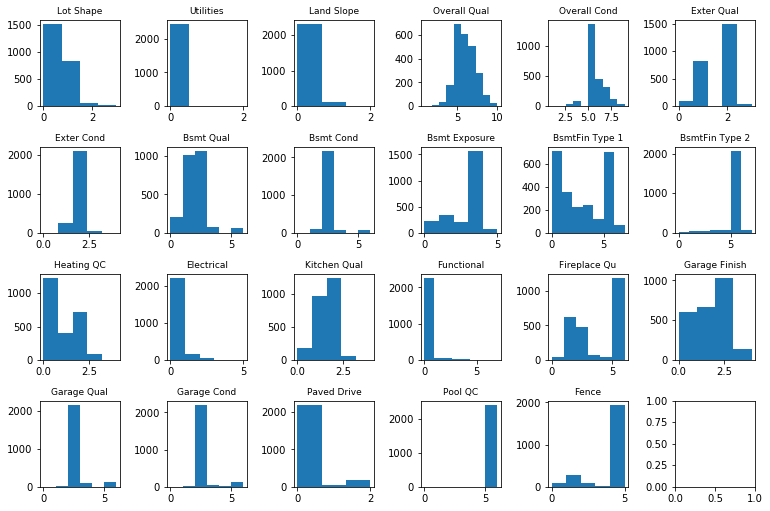

In [23]:
if gcblnShowDiagrams:
    SimpleDistributionPlots(dfrOrdinalNoMissings, lstrOrdinal)

__Conclusions:__
* Some distributions depart from normality, e.g. `Land Slope`.
* I will try out some standard transformations.

In [24]:
import numpy as np
def ColumnsTransformed(dfrOriginalData, lstrColumns, strFunction):
    '''Transforms some columns of a dataframe'''
    
    # init
    dfrNewData = dfrOriginalData.copy()
    strFunction = strFunction.lower()
    
    # transform
    for strColumn in lstrColumns:
        if strFunction == "ln": # avoid "log" for ambiguity
            dfrNewData[strColumn] = np.log(dfrNewData[strColumn])
        if strFunction == "lnp1": # avoid "log" for ambiguity
            dfrNewData[strColumn] = np.log(dfrNewData[strColumn] + 1)
        elif strFunction == "log10": 
            dfrNewData[strColumn] = np.log10(dfrNewData[strColumn])
        elif strFunction == "log10p1": 
            dfrNewData[strColumn] = np.log10(dfrNewData[strColumn] + 1)
        elif strFunction == "root": 
            dfrNewData[strColumn] = dfrNewData[strColumn] ** 0.5
        elif strFunction == "square": 
            dfrNewData[strColumn] = dfrNewData[strColumn] ** 2
        elif strFunction == "cube": 
            dfrNewData[strColumn] = dfrNewData[strColumn] ** 3
        elif strFunction == "none": 
            pass # just for completeness            
        else:
            print ("Strange Function in ColumnsTransformed():", strFunction)
    
    # finalize
    return dfrNewData

TRANSFORMATION: NONE


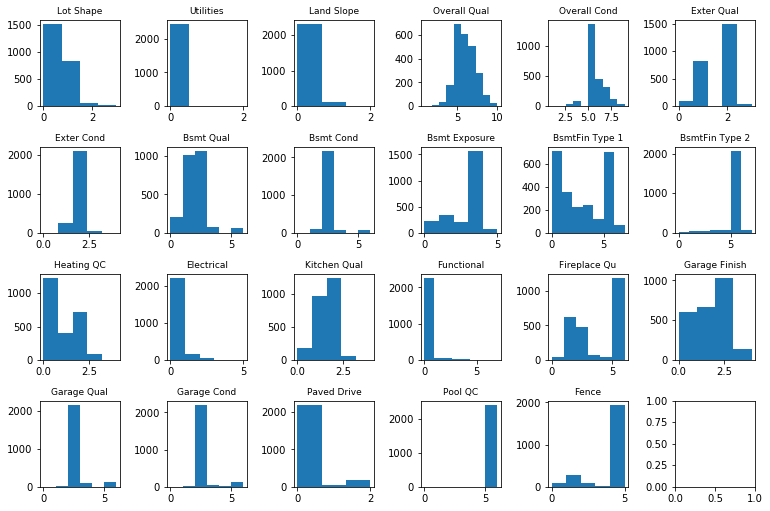

TRANSFORMATION: LOG10P1


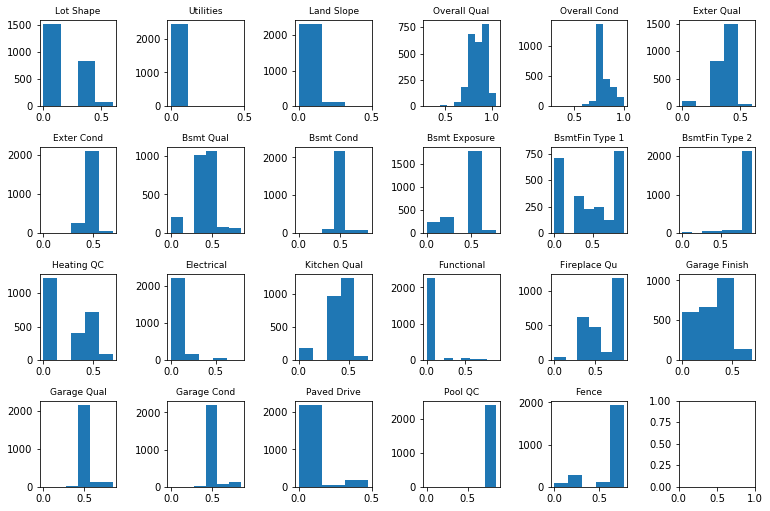

TRANSFORMATION: ROOT


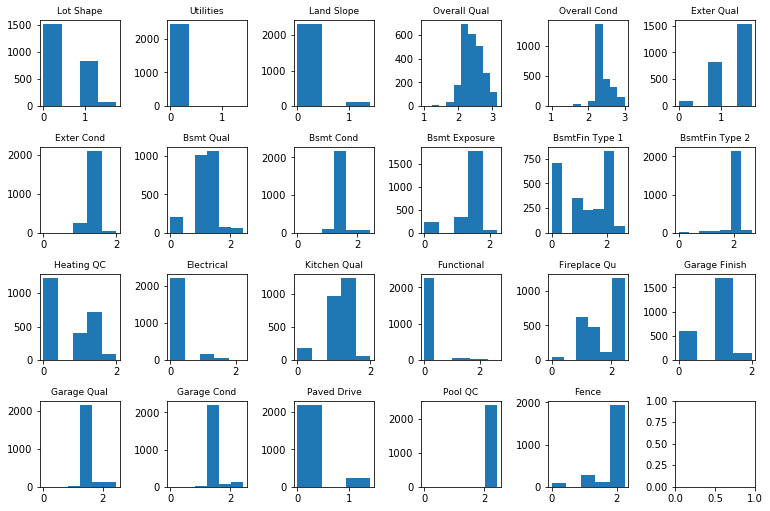

TRANSFORMATION: SQUARE


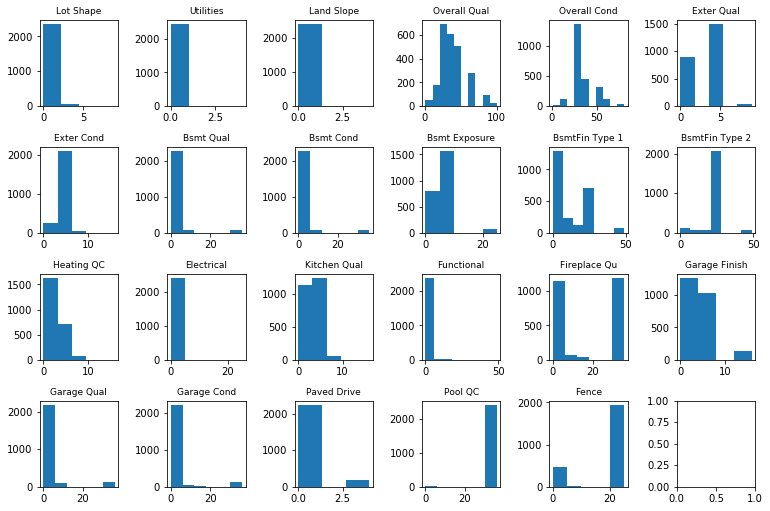

TRANSFORMATION: CUBE


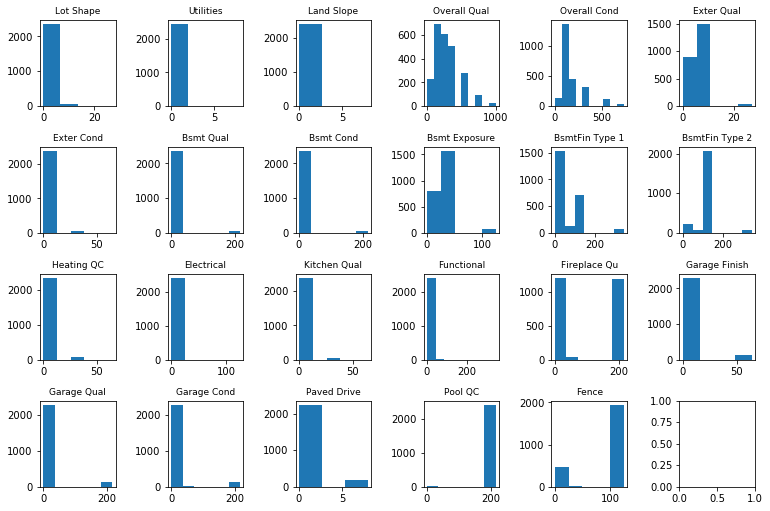

In [25]:
if gcblnShowDiagrams:
    lstrTransformations = ["none", "log10p1", "root", "square","cube"] # logarithms without adding 1 are not possible because of the occurence of 0
    for strTransformation in lstrTransformations:
        print("Transformation:".upper(), strTransformation.upper())
        SimpleDistributionPlots(ColumnsTransformed(dfrOrdinalNoMissings, lstrOrdinal, strTransformation), lstrOrdinal)

__Conclusions:__
* Many distributions of the ordinal variables do not look normal, even after transformation.
* Yet, many distributions probably do not differ from a normal distribution in a statistically significant way, as there are only a few bins per column.
* I will transform some of the ordinal columns, but rather conservatively (i.e. no transformation if none is a clear improvement).
* A cubic transformation never makes sense.
* In the next step, the decisions on the transformations will be packed into a list.

In [26]:
# define transformation for each ordinal column, for later use
lstrOrdinalTransformations = []
lstrOrdinalLog10P1 = ["Lot Shape", "Exter Qual", "Bsmt Qual", "Kitchen Qual", "Functional", "Fireplace Qu"]
lstrOrdinalRoot = ["Land Slope","Electrical"]
lstrOrdinalSquare = ["Overall Qual"]
lstrOrdinalCube = []
for strOrdinal in lstrOrdinal:
    if strOrdinal in lstrOrdinalLog10P1:
        strTransformation = "log10p1"
    elif strOrdinal in lstrOrdinalRoot:
        strTransformation = "root"
    elif strOrdinal in lstrOrdinalSquare:
        strTransformation = "square"
    elif strOrdinal in lstrOrdinalCube:
        strTransformation = "cube"
    else:
        strTransformation = "none"
    lstrOrdinalTransformations.append(f"{strOrdinal}:{strTransformation}")

__Check discrete data__:

In [27]:
# check missing data
dfrOrdinalNoMissings[lstrDiscrete].isnull().sum()

Year Built          0
Year Remod/Add      0
Bsmt Full Bath      2
Bsmt Half Bath      2
Full Bath           0
Half Bath           0
Bedroom AbvGr       0
Kitchen AbvGr       0
TotRms AbvGrd       0
Fireplaces          0
Garage Yr Blt     138
Garage Cars         1
Mo Sold             0
Yr Sold             0
dtype: int64

In [28]:
print("Ranges of discrete variables:")
dfrOrdinalNoMissings[lstrDiscrete].describe().loc[['min','max']].T.astype(int)

Ranges of discrete variables:


,min,max
Year Built,1875,2010
Year Remod/Add,1950,2010
Bsmt Full Bath,0,3
Bsmt Half Bath,0,2
Full Bath,0,4
Half Bath,0,2
Bedroom AbvGr,0,8
Kitchen AbvGr,0,3
TotRms AbvGrd,2,15
Fireplaces,0,4


In [29]:
print("Last years of building garages:")
dfrOrdinalNoMissings["Garage Yr Blt"].dropna().sort_values().tail()

Last years of building garages:


1120    2010.0
371     2010.0
1261    2010.0
506     2010.0
2219    2207.0
Name: Garage Yr Blt, dtype: float64

__Conclusions:__
* Most discrete column don't have any `NaN`.
* `NaN`in baths in basements are most probably do to missing a basement entirely.
* Therefore, setting `NaN`to 0, seems reasonable.
* With the construction year of the garage, I consider having no garage is about as bad as having a very old garage. Therefore I transform `NaN`into `1875`.
* I force years into 1875 to 2010, assuming that the last 2 digits are correct.
* In the following step, I define pragmatic upper cut-offs, based on the train data. To be fully correct, one should do that only after splitting the train set into the train set sensu stricto and the validation set. In the following function `CleanDiscreteColumns`, this would mean that the dictionary `dintMaxima` should not be filled here with the maxima observed in the entire train set, but with the 80% train set (i.e. without the 20% validation set). However, I do not expect any major differences in the outcome of the analyses to follow.

In [30]:
import pandas as pd
def CleanDiscreteColumns(dfrOriginalData, lstrColumns):
    '''For discrete columns, clean values'''
    
    # init
    dfrNewData = dfrOriginalData.copy()
    lstrYears  = ["Year Built", "Year Remod/Add","Garage Yr Blt", "Yr Sold"]
    lstrMonths = ["Mo Sold"]
    cintMinYear = 1875
    cintMaxYear = 2010
    cintRandomMonth = 7
    cintMaxTotalRoomsAboveGround = 15
    
    # loop through columns
    for strColumn in lstrColumns:

        # NaN handling
        if strColumn in lstrYears:
            intReplacement = cintMinYear
        else:
            intReplacement = 0
        dfrNewData[strColumn] = dfrNewData[strColumn].fillna(intReplacement)
        
        if strColumn in lstrYears:
            # force year into 1875 - 2010
            dfrNewData.loc[dfrNewData[strColumn] < cintMinYear, strColumn] = dfrNewData[strColumn] % 100  # minimum
            dfrNewData.loc[dfrNewData[strColumn] > cintMaxYear, strColumn] = dfrNewData[strColumn] % 100  # maximum
            dfrNewData.loc[dfrNewData[strColumn] < 100,         strColumn] = dfrNewData[strColumn] + 1900 # try 19xx
            dfrNewData.loc[dfrNewData[strColumn] < cintMinYear, strColumn] = dfrNewData[strColumn] + 100  # add a centery
            dfrNewData.loc[dfrNewData[strColumn] > cintMaxYear, strColumn] = cintMaxYear                  # maximum again
        elif strColumn in lstrMonths:  
            dfrNewData.loc[dfrNewData[strColumn] < 1,  strColumn] = cintRandomMonth
            dfrNewData.loc[dfrNewData[strColumn] > 12, strColumn] = cintRandomMonth
        else:

            # discard negative values
            dfrNewData.loc[dfrNewData[strColumn] < 0,  strColumn] = 0
            
            # define pragmatic upper cut-offs, based on train data
            dintMaxima = {
                'Bsmt Full Bath': 3,
                'Bsmt Half Bath': 2,
                'Full Bath': 4,
                'Half Bath': 2,
                'Bedroom AbvGr': 8,
                'Kitchen AbvGr': 3,
                'TotRms AbvGrd': 15,
                'Fireplaces': 4,
                'Garage Cars': 4
            }
            
            # apply cut-offs
            intMax = dintMaxima[strColumn]
            cdblToleranceFactor = 1.5
            intCutOff = np.round(intMax * cdblToleranceFactor)
            dfrNewData.loc[dfrNewData[strColumn] > intCutOff,  strColumn] = intCutOff

    # finalize   
    return dfrNewData

In [31]:
if False: # debugging
    print("Test: Data-cleaning of discrete columns".upper(),"\n")
    dfrTest = pd.DataFrame({"Year Remod/Add":[1870,1875,1907,1950,1951,2007,2010,2017,2222, np.nan],
                           "Fireplaces":[-1,0,3,4,5,6,9,10,11,np.nan]})
    lstrTest = dfrTest.columns
    print("BEFORE", dfrTest.T.values.astype(int))
    dfrTest = CleanDiscreteColumns(dfrTest, lstrTest)
    print("AFTER ", dfrTest.T.values.astype(int))

In [32]:
print("Cleaned discrete data:".upper())
dfrCleanedDiscreteColumns = CleanDiscreteColumns(dfrOrdinalNoMissings, lstrDiscrete)
dfrCleanedDiscreteColumns[lstrDiscrete].describe().loc[['min','max']].T.astype(int).T

CLEANED DISCRETE DATA:


,Year Built,Year Remod/Add,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Mo Sold,Yr Sold
min,1875,1950,0,0,0,0,0,0,2,0,1875,0,1,2006
max,2010,2010,3,2,4,2,8,3,15,4,2010,4,12,2010


TRANSFORMATION: NONE


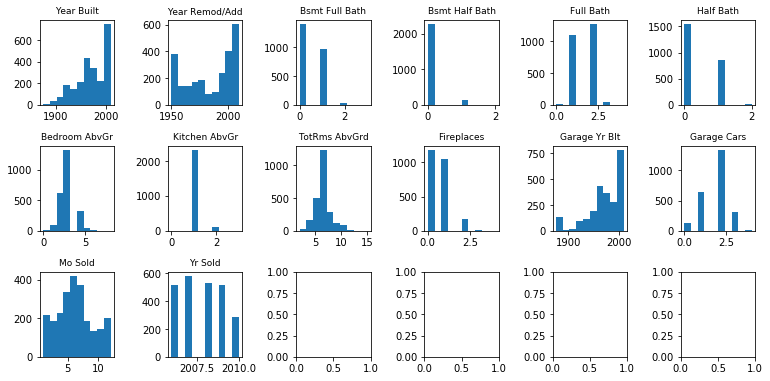

TRANSFORMATION: LOG10P1


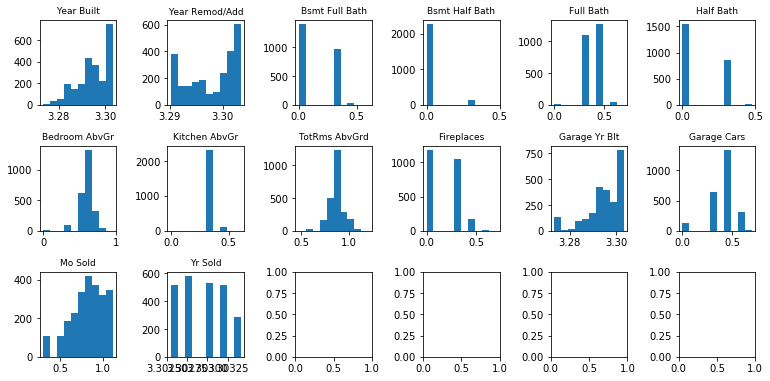

TRANSFORMATION: ROOT


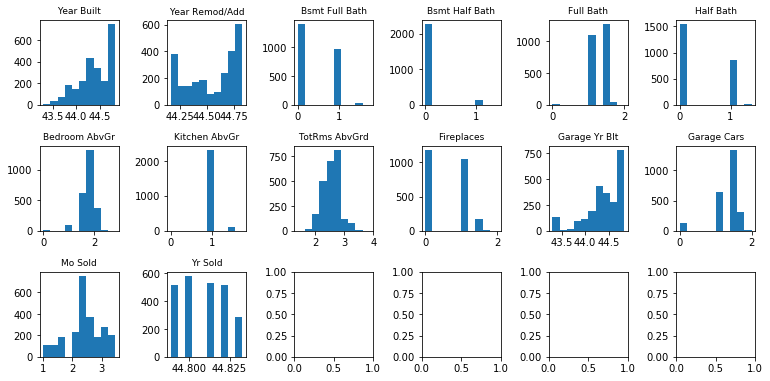

TRANSFORMATION: SQUARE


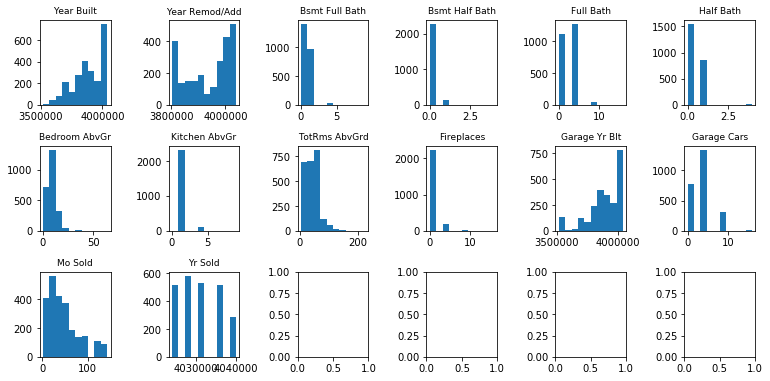

TRANSFORMATION: CUBE


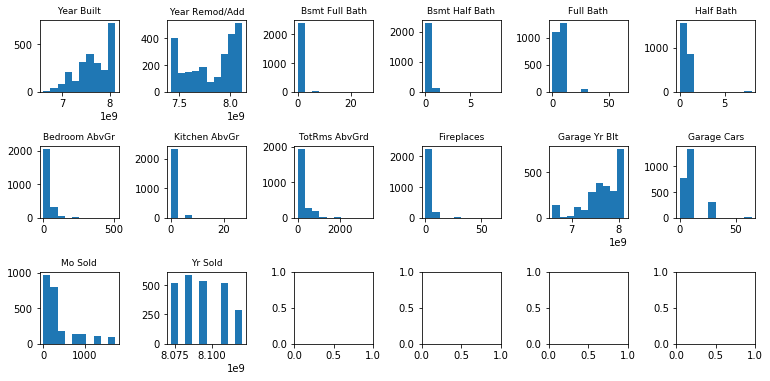

In [33]:
if gcblnShowDiagrams:
    lstrTransformations = ["none", "log10p1", "root", "square","cube"] # logarithms without adding 1 are not possible because of the occurence of 0
    for strTransformation in lstrTransformations:
        print("Transformation:".upper(), strTransformation.upper())
        SimpleDistributionPlots(ColumnsTransformed(dfrCleanedDiscreteColumns, lstrDiscrete, strTransformation), lstrDiscrete, 10)

__Conclusions:__
* As with ordinal data, many distributions probably do not differ from a normal distribution in a statistically significant way.
* I will transform some of the discrete columns, but rather conservatively.
* If any, only the `log10p1` transformation improves the distribution.
* Caveat: The spelling of `TotRms AbvGrd` differs from other "above-ground" variables: there is a "d" in the end.
* In the next step, the decisions on the transformations will be packed into a list.

In [34]:
# define transformation for each discrete column, for later use
lstrDiscreteTransformations = []
lstrDiscreteLog10P1 = ["Bsmt Full Bath", "Bsmt Half Bath", "Full Bath", "Half Bath", "Bedroom AbvGr", "Kitchen AbvGr", "TotRms AbvGrd", "Fireplaces", "Garage Cars"]
lstrDiscreteRoot = []
lstrDiscreteSquare = []
lstrDiscreteCube = []
for strDiscrete in lstrDiscrete:
    if strDiscrete in lstrDiscreteLog10P1:
        strTransformation = "log10p1"
    elif strDiscrete in lstrDiscreteRoot:
        strTransformation = "root"
    elif strDiscrete in lstrDiscreteSquare:
        strTransformation = "square"
    elif strDiscrete in lstrDiscreteCube:
        strTransformation = "cube"
    else:
        strTransformation = "none"
    lstrDiscreteTransformations.append(f"{strDiscrete}:{strTransformation}") 

__Remarks on years and month values:__
* The features containing calendar years may be changed into age values (feature engineering), and transformations may be reconsidered then.
* The month values `Mo Sold` are discrete, however they are circular, not linear: 1 (i.e. January) has the same distance to both 2 and 12, which is not taken into consideration, if we treat months like any other discrete feature.
* Therefore, the months should be handled like nominal data (although the connection among adjacent months is lost by doint that).
* Maybe the month should be feature-engineered into seasons and handled as categories then (not done though).
* I could use both the season approach and add the months as a decimal fraction to the year.

__Check continuous data:__

In [35]:
# check missing data
dfrCleanedDiscreteColumns[lstrContinuous].isnull().sum()

Lot Frontage       420
Lot Area             0
Mas Vnr Area        20
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Total Bsmt SF        1
1st Flr SF           0
2nd Flr SF           0
Low Qual Fin SF      0
Gr Liv Area          0
Garage Area          1
Wood Deck SF         0
Open Porch SF        0
Enclosed Porch       0
3Ssn Porch           0
Screen Porch         0
Pool Area            0
Misc Val             0
dtype: int64

In [36]:
print("Ranges of continuous variables:")
dfrCleanedDiscreteColumns[lstrContinuous].describe().loc[['min','50%', 'max']].T.astype(int)

Ranges of continuous variables:


,min,50%,max
Lot Frontage,21,68,313
Lot Area,1470,9500,215245
Mas Vnr Area,0,0,1600
BsmtFin SF 1,0,375,5644
BsmtFin SF 2,0,0,1526
Bsmt Unf SF,0,462,2336
Total Bsmt SF,0,990,6110
1st Flr SF,334,1086,5095
2nd Flr SF,0,0,2065
Low Qual Fin SF,0,0,1064


__Conclusions:__
* Most continuous column don't have many `NaN`.
* The documentation defines `Lot frontage` (which contains most `NaN`) as: "linear feet of street connected to property" (not fully clear what that means; German: "Lineare Straßenlänge, die mit dem Grundstück verbunden ist"). There are two options, as far as I can see: (1) There is no connection to a street nearby (2) The distance has not been measured. For a U.S. American town such as Ames IA, option 1 seems very improbable to me. Thus assuming option 2, I set all `NaN`to the median, i.e. 68.
* For the other variables, it seems reasonable to me to set `NaN` to 0. Example: Most houses have a median of `Mas Vnr Area` of 0.
* In the following step, as it was the case for `CleanDiscreteColumns`, one should not build the dictionary `dintMaxima`from the entire train set, but only after the train / validation split. Again, however, I do not expect huge differences.

In [37]:
import pandas as pd
def CleanContinuousColumns(dfrOriginalData, lstrColumns):
    '''For continuous columns, clean values'''
    
    # init
    dfrNewData = dfrOriginalData.copy()
    cdblLotFrontageMedian = 68
    
    # loop through columns
    for strColumn in lstrColumns:

        # NaN handling
        if strColumn == "Lot frontage":
            intReplacement = cdblLotFrontageMedian
        else:
            intReplacement = 0
        dfrNewData[strColumn] = dfrNewData[strColumn].fillna(intReplacement)

        # discard negative values
        dfrNewData.loc[dfrNewData[strColumn] < 0,  strColumn] = 0

        # define pragmatic upper cut-offs, based on train data
        dintMaxima = {
            'Lot Frontage': 313,
            'Lot Area': 215245,
            'Mas Vnr Area': 1600,
            'BsmtFin SF 1': 5644,
            'BsmtFin SF 2': 1526,
            'Bsmt Unf SF': 2336,
            'Total Bsmt SF': 6110,
            '1st Flr SF': 5095,
            '2nd Flr SF': 2065,
            'Low Qual Fin SF': 1064,
            'Gr Liv Area': 5642,
            'Garage Area': 1488,
            'Wood Deck SF': 1424,
            'Open Porch SF': 742,
            'Enclosed Porch': 1012,
            '3Ssn Porch': 508,
            'Screen Porch': 490,
            'Pool Area': 800,
            'Misc Val': 17000
        }

        # apply cut-offs
        intMax = dintMaxima[strColumn]
        cdblToleranceFactor = 1.5
        intCutOff = np.round(intMax * cdblToleranceFactor)
        dfrNewData.loc[dfrNewData[strColumn] > intCutOff,  strColumn] = intCutOff

    # finalize   
    return dfrNewData

In [38]:
print("Cleaned continuous data:".upper())
dfrCleanedContinuousColumns = CleanContinuousColumns(dfrCleanedDiscreteColumns, lstrContinuous)
dfrCleanedContinuousColumns[lstrContinuous].describe().loc[['min','max']].T.astype(int).T

CLEANED CONTINUOUS DATA:


,Lot Frontage,Lot Area,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val
min,0,1470,0,0,0,0,0,334,0,0,334,0,0,0,0,0,0,0,0
max,313,215245,1600,5644,1526,2336,6110,5095,2065,1064,5642,1488,1424,742,1012,508,490,800,17000


TRANSFORMATION: NONE


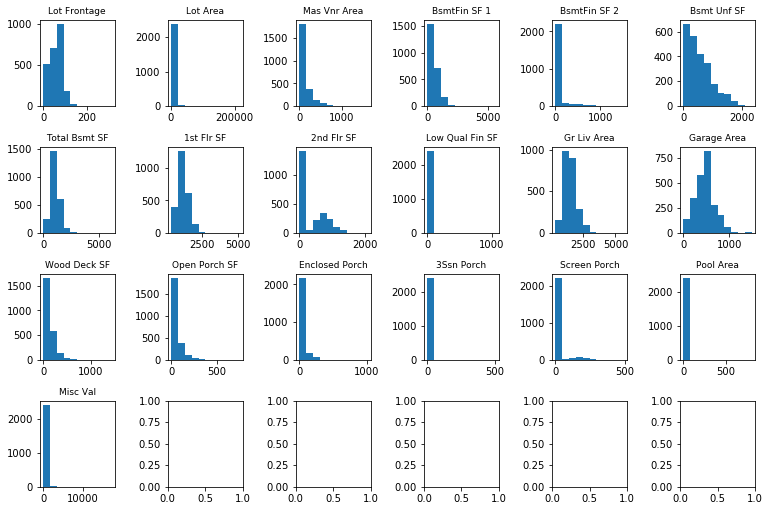

TRANSFORMATION: LOG10P1


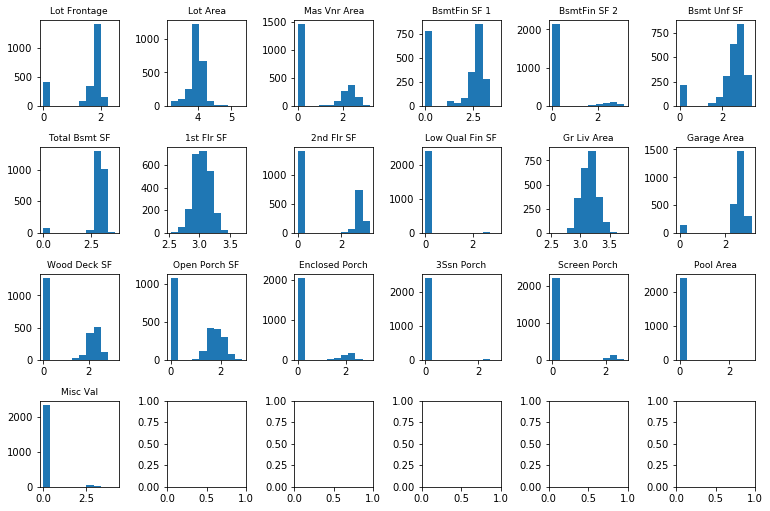

TRANSFORMATION: ROOT


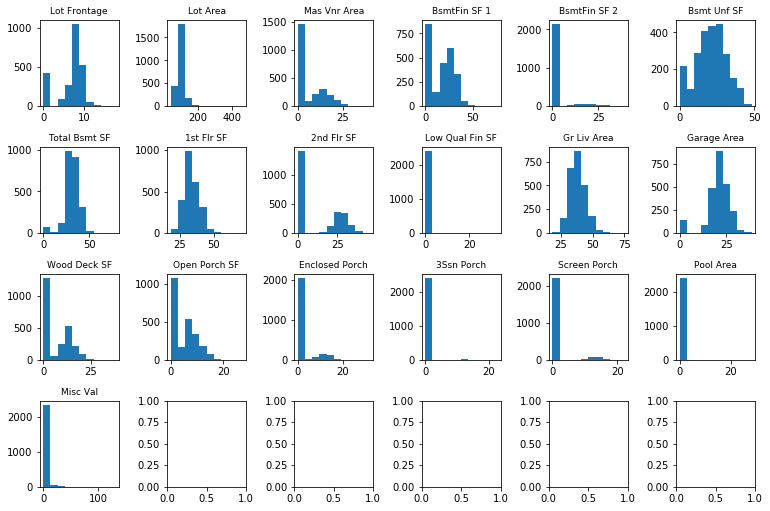

TRANSFORMATION: SQUARE


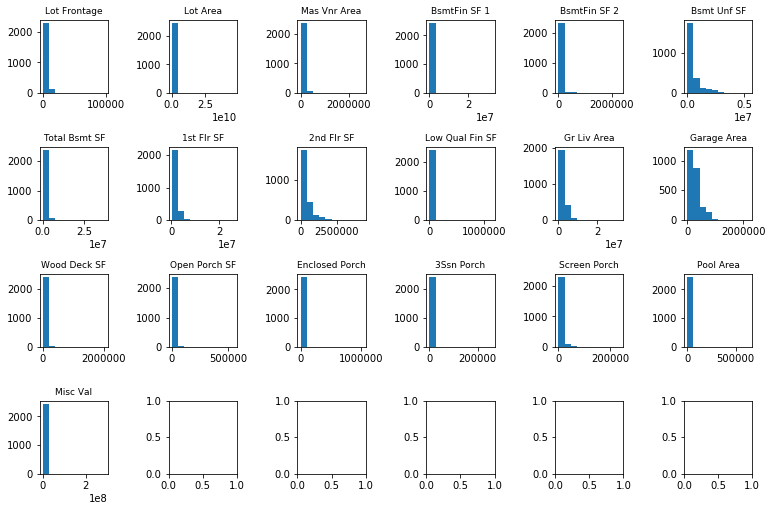

TRANSFORMATION: CUBE


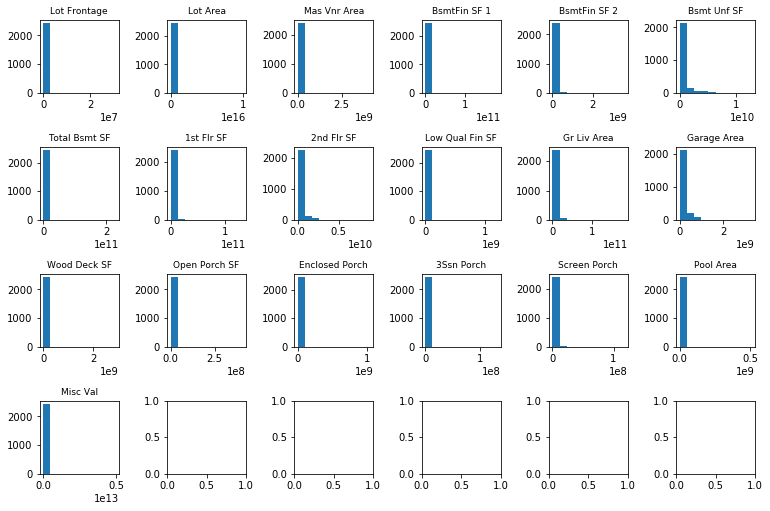

In [39]:
if gcblnShowDiagrams:
    lstrTransformations = ["none", "log10p1", "root", "square","cube"] # logarithms without adding 1 are not possible because of the occurence of 0
    for strTransformation in lstrTransformations:
        print("Transformation:".upper(), strTransformation.upper())
        SimpleDistributionPlots(ColumnsTransformed(dfrCleanedContinuousColumns, lstrContinuous, strTransformation), lstrContinuous, 10)

__Conclusions:__
* Actually, continuous features also consist of integer values, not float numbers (like discrete features).
* Most continuous features seem best be transformed using the root transformation.
* Features such as `2nd Flr SF` (area on the second floor) contain lots of `0`values, which yields a bimodal distribution. Such features may be combined with others (here `1st Flr SF`) to create a more normally distributed sum plus a boolean feature such as `Has 2nd Floor` (feature engineering).
* In the next step, the decisions on the transformations will be packed into lists.

In [40]:
# define transformation for each continuous column, for later use
lstrContinuousTransformations = []
lstrContinuousLog10P1 = ["Lot Area", "Gr Liv Area"]
lstrContinuousRoot = ["Lot Frontage", "Mas Vnr Area", "BsmtFin SF 1", "BsmtFin SF 2", "Bsmt Unf SF", "Total Bsmt SF", 
                      "1st Flr SF", "2nd Flr SF", "Low Qual Fin SF", "Wood Deck SF", "Open Porch SF", "Enclosed Porch", 
                      "3Ssn Porch", "Screen Porch", "Pool Area", "Misc Val"]
lstrContinuousSquare = []
lstrContinuousCube = []
for strContinuous in lstrContinuous:
    if strContinuous in lstrContinuousLog10P1:
        strTransformation = "log10p1"
    elif strContinuous in lstrContinuousRoot:
        strTransformation = "root"
    elif strContinuous in lstrContinuousSquare:
        strTransformation = "square"
    elif strContinuous in lstrContinuousCube:
        strTransformation = "cube"
    else:
        strTransformation = "none"
    lstrContinuousTransformations.append(f"{strContinuous}:{strTransformation}")   

## Data cleaning

### Big houses
* Dean De Cock, the author of the data set, suggests: _"There are five observations that an instructor may wish to remove from the data set before giving it to students (a plot of `SALE PRICE` versus `GR LIV AREA` will quickly indicate these points)"_.
* This shall be investigated in the following step.
* As `SalePrice` has already been transformed, `dfrRawTrainData` has to be used in the first diagram.

DETECTING OUTLIERS: ABOVE GRADE (GROUND) LIVING AREA SQUARE FEET

RAW SCALE:


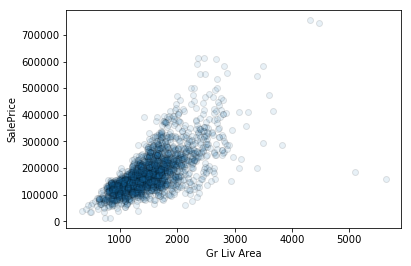

DOUBLE LOG SCALE:


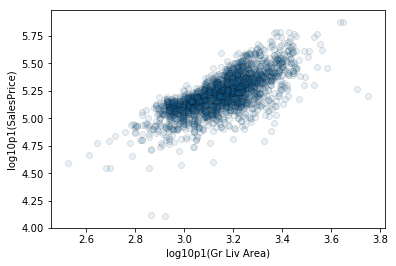


LARGEST LIVING AREAS:
647     3608.0
306     3672.0
2056    3820.0
237     4316.0
102     4476.0
71      5095.0
1500    5642.0
Name: Gr Liv Area, dtype: float64
LOWEST PRICES:
1757    12789
491     13100
977     34900
1654    35000
2379    35311
1857    37900
234     39300
Name: SalePrice, dtype: int64

SALE PRICE RANGE:


In [41]:
if gcblnShowDiagrams:

    # scatter plot
    #plt.scatter(dfrCleanedContinuousColumns['Gr Liv Area'], np.log10(dfrCleanedContinuousColumns['LogPrice']+1), edgecolor='black', alpha=0.1)
    print("Detecting outliers: Above grade (ground) living area square feet\n".upper())
    print("Raw scale:".upper())
    plt.scatter(dfrCleanedContinuousColumns['Gr Liv Area'], dfrRawTrainData['SalePrice'], edgecolor='black', alpha=0.1)
    plt.xlabel('Gr Liv Area')
    plt.ylabel("SalePrice")
    plt.show()
    print("Double log scale:".upper())
    plt.scatter(np.log10(dfrCleanedContinuousColumns['Gr Liv Area']+1), dfrCleanedContinuousColumns['LogPrice'], edgecolor='black', alpha=0.1)
    plt.xlabel('log10p1(Gr Liv Area)')
    plt.ylabel("log10p1(SalesPrice)")
    plt.show()
    print("\nLargest living areas:".upper())
    print(dfrCleanedContinuousColumns['Gr Liv Area'].sort_values().T.tail(7))
    print("Lowest prices:".upper())
    print(dfrRawTrainData['SalePrice'].sort_values().T.head(7))
    print("\nSale price range:".upper())
    dfrRawTrainData['SalePrice'].describe().loc[['min','max']].astype(int)

__Conclusions:__
* I can detect only 4 houses with distinctly larger living areas, i.e. `> 4000` square feet (the author mentions 5 of them).
* These 4 houses can be considered as outliers within the raw scales.
* When the data is log-scaled (`log10p1`), these 4 houses should not be considered as outliers.
* If any, then those 2 low-price houses (`< 15000`) should be removed.
* I decide to keep all of the rows as, on the double log-scale, the homoscedasticity seems not to be hampered too much and the data set should be big enough to compensate for any irregularities introduced by the two low-price houses.
* I will clip the very final sale price predictions by turning potential negative values into 0.

### Data deletion
* As a general rule, record deletion makes sense only in the train set: the test data set must be considered as a given.
* I have no strong reasons to delete records from the train set; see reasons above why not to remove high-price and low-price houses.
* The only deletion I apply is the removal of the column `Order`, which means only a minor adjustment, irrelevant to the analysies. This adjustment is implemented in the next step:

In [42]:
cblnIsTrain = True
cblnIsTest = False

__Defining some utility functions for data cleaning purposes:__

In [43]:
import math
def DeltaSeries(srs1, srs2):
    '''Calculates differences between two series, ignoring NaN.'''
    # Work-around; probably there is an elegant standard solution.
    
    # init
    intRows1 = srs1.shape[0]
    intRows2 = srs2.shape[0]
    lstrDelta = []
    
    # show-stopper
    if intRows1 != intRows2:
        print(f"The two series in DeltaSeries must have same length. Currently {intRows1} != {intRows2}")
        
    # loop through rows
    for intRow in range(srs1.shape[0]):
        varEntry1 = srs1.loc[intRow]
        varEntry2 = srs2.loc[intRow]
        blnRemember = False
        if isinstance(varEntry1, str): 
            if isinstance(varEntry2, str):
                if varEntry1 != varEntry2:
                    blnRemember = True
            else:
                blnRemember = True
        else:
            if isinstance(varEntry2, str):
                blnRemember = True
            else: # both non-strings
                if math.isnan(varEntry1) or math.isnan(varEntry2):
                    pass
                else:
                    if varEntry1 != varEntry2:
                        blnRemember = True                    

        if blnRemember:
            lstrDelta.append(f"{varEntry1} != {varEntry2}")     

    # finalize
    return lstrDelta

if False:
    df = pd.DataFrame({"S1":[1,2,3,np.nan,np.nan,5,"Peter","Anna"],"S2":[1,22,np.nan,4,np.nan,55, "Paul","Anna"]})
    srsBefore = df["S1"]
    srsAfter = df["S2"]
    print(DeltaSeries(srsBefore,srsAfter))
    
def DataDeletion(dfrSource, blnTrain):
    '''Deletes some data from dataframe (only tiny adjustments though).'''
    
    # init
    dfrResult = dfrSource.copy()
    
    # delete 'Order' column
    dfrResult.drop ("Order", axis=1, inplace=True) 
    
    # finalize
    return dfrResult

def StringDistanceCaseSensitive(strOne, strTwo)->tuple:
    '''Calculates a distance between two strings (work-around for the Levenshtein function).'''
    
    # init
    intBest = -1
    blnFound = False
    
    # order strings by length
    strLong, strShort = strOne, strTwo
    if len(strOne) < len(strTwo):
        strLong, strShort = strTwo, strOne
    intLong, intShort = len(strLong), len(strShort)
    
    intBestNumerator = 0
    
    for intRemove in range(intShort):
        
        for intShortStart in range(intShort):
            strChunk = strShort[intShortStart: intShort - intRemove]
            
            if strChunk != "":
                intChunkLength = len(strChunk)

                for intCheckPos in range(intLong - intChunkLength + 1):
                    strTester = strLong[intCheckPos:intCheckPos+intChunkLength]
                    ###print (f"strChunk = {strChunk} strTester = {strTester}")
                    if strChunk == strTester:
                        if intChunkLength > intBestNumerator:
                            intBestNumerator = intChunkLength

    # finalize
    return (intBestNumerator, intLong)

if False: # debugging
    print(StringDistanceCaseSensitive("Danilo","Daniel"))
if False: # debugging
    lstrTesters = ["Clara","Claras","Klara","x"]
    for strTester in lstrTesters:
        print(strTester, StringDistanceCaseSensitive(strTester,"Clara"))  

def StringDistance(strOne, strTwo)-> float:
    '''Calculates a distance between two strings, with a penalty for upper-case/lower-case differences. Result: float from 0 to 1.'''
    
    if strOne == strTwo:
        # show-stopper
        dblResult = 1
    else:
        # calculate string distances: both raw and lower-case
        cintPenaltyFactor = 0.9
        intNumerator1, intDenominator1 = StringDistanceCaseSensitive(strOne, strTwo) # raw
        intNumerator2, intDenominator2 = StringDistanceCaseSensitive(strOne.lower(), strTwo.lower()) # same case
        intNumerator2 *= cintPenaltyFactor
        dblResult = max(intNumerator1, intNumerator2) / intDenominator2

    # finalize
    return dblResult

if False: # debugging
    lstrTesters = ["Anna","Petra","Peter","peter","tero","Peterkos","peterkos","Pedro","Pierre","Peter Heeb"]
    for strTester in lstrTesters:
        print(strTester, StringDistance(strTester,"Peter"))  
        
def BestMatchFromList(strText, lstrCategories)-> str:
    '''Finds the best string match from a list.'''    
    
    blnAtStart = True
    for strCategory in lstrCategories:
        fltDistance = StringDistance (strText, strCategory)
        blnRemember = False
        if blnAtStart:
            blnRemember = True
            blnAtStart = False
        elif fltDistance > fltBestDistance:
            blnRemember = True
        if blnRemember:
            fltBestDistance = fltDistance
            strBestMatch = strCategory
            
    # finalize
    return strBestMatch

if False: # debugging
    lstrTesters = ["Anna","anna","Ann","Klara","BERT","dito","Danilo","Chiara","Dominik"]
    lstrCategories = ["Anna","Berta","Clara","Daniel","Edith"]
    for strTester in lstrTesters:
        print(strTester, " -> ", BestMatchFromList(strTester, lstrCategories))  

def CastArrayToStringListDroppingNan(avarSource):
    '''Casts numbers into strings, but keeps NaN.'''
    # work-around
    # there is probably a more elegant way to do this (np.delete?)
    # does not work, if the string 'nan' is a true, acceptable string value
    
    # init
    lstrResult = []
    
    # cast and skip
    for varElement in avarSource:
        strElement = str(varElement)
        if strElement != "nan":
            lstrResult.append(strElement)
    
    # finalize
    return lstrResult

def ForcedCategories(dfrSource, strColumn, lstrCategories, blnReportChanges=False):
    '''Forces the column entries of a dataframe into a set of possible categories.'''
    
    # init
    dfrResult = dfrSource.copy()
    avarUniqueEntries = dfrResult[strColumn].unique()
    lstrUniqueEntries = CastArrayToStringListDroppingNan(avarUniqueEntries)
    lstrTranslations = []
    
    # remember state before
    if blnReportChanges:
        srsBefore = dfrSource[strColumn]
    
    # translate categories
    for strUniqueEntry in lstrUniqueEntries:
        strTranslation = BestMatchFromList(strUniqueEntry, lstrCategories)
        lstrTranslations.append(strTranslation)

    # replace entries by translation
    intTranslations = 0
    for intIndex in range(len(lstrTranslations)):
        strEntry = lstrUniqueEntries[intIndex]
        strTranslation = lstrTranslations[intIndex]
        if strEntry != strTranslation:
            dfrResult.replace({strEntry: strTranslation}, inplace=True)
            print("Translates misspelled category: ",strEntry ,"to", strTranslation)
            intTranslations += 1
    
    # report on changes
    if blnReportChanges:
        srsAfter = dfrResult[strColumn]
        lstrDelta = DeltaSeries(srsBefore, srsAfter)
        intCorrectionCount = len(lstrDelta)
        if intCorrectionCount > 0: 
            print(f"   Total typos in column '{strColumn}': {intCorrectionCount} (unique = {intTranslations})")
    
    # finalize
    return dfrResult

if False: # debugging
    dfrTest = pd.DataFrame({"Neighborhoods":["alfa","Betha", "gama", "DELT", "gama", "Gamma", np.nan, "BETA"]})
    lstrTestCategories = ["Alpha", "Beta", "Gamma"]
    blnReportChanges = True
    dfrTest = ForcedCategories(dfrTest, "Neighborhoods", lstrTestCategories, blnReportChanges)    
    
def ParenthesesRemoved(dfrSource, strColumn):
    '''Removes parentheses from the values of a column.'''
    
    dfrResult = dfrSource.copy()
    regParenthesesPattern = r"\s*\(.*\)"
    dfrResult[strColumn] = dfrResult[strColumn].str.replace(regParenthesesPattern,"")
    return dfrResult

if False: # debugging
    dfrTest = pd.DataFrame({"Neighborhoods":["Alpha (1)", "Beta    (2 or two) Xi", "Gamma (never)"]})
    dfrTest = ParenthesesRemoved(dfrTest, "Neighborhoods")
    print(dfrTest)     
    
def PutTrueNan (dfrSource, strPseudoNan):
    '''Converts raw NA strings into Numpy NaN.'''
    dfrResult = dfrSource.copy()
    dfrResult = dfrResult.replace('NA', np.nan)
    return dfrResult
if False:
    dfrTest = pd.DataFrame({"Houses":["alpha","NA","NA"],"Prices":[1000,"NA",3000]})
    dfrTest = PutTrueNan (dfrTest, "NA")
    print(dfrTest)
    
def ColumnsTransformedIndividually (dfrSource, lstrTransformations):
    '''Tranforms numeric columns, with individual transformation functions.'''
    
    # init
    dfrResult = dfrSource.copy()
    
    # apply individual transformation for each column
    for strFeatureAndTransformation in lstrTransformations:
        strColumn, strTransformationFunction = strFeatureAndTransformation.split(":")
        lstrColumn = [strColumn] # as a list, for compatibility
        dfrResult = ColumnsTransformed(dfrResult, lstrColumn, strTransformationFunction) # core
        
    # finalize
    return dfrResult

if False:
    dfrTest = ColumnsTransformedIndividually(dfrLogTrainData, lstrDiscreteTransformations)
    print("------------------------------------------------------------")
    print(dfrLogTrainData[lstrDiscrete].head(3))
    print("------------------------------------------------------------")
    print(dfrTest[lstrDiscrete].head(3))    

In [44]:
def DataCleaning(dfrSource, blnTrain):
    '''Performs all data-cleaning within a single function.'''
    
    # init
    dfrResult = dfrSource.copy()
    
    # cleaning...
    
    # ... general
    dfrResult = PutTrueNan (dfrResult, "NA")
    dfrResult = ParenthesesRemoved(dfrResult, "MS Zoning")
    
    # ... all categories
    glstrProblematicColumns = []
    for strColumn in lstrNominal + lstrOrdinal:
        lstrCategories = dlstrCategories[strColumn]
        dfrResult = ForcedCategories(dfrResult, strColumn, lstrCategories, blnReportChanges=True)
    
    # ... ordinal categories
    dfrResult = OrdinalToDiscrete(dlstrCategories, dfrResult, lstrOrdinal)
    dfrResult = ConvertOrdinalNan(dlstrCategories, dfrResult, lstrOrdinal)
    
    # ... discrete columns
    dfrResult = CleanDiscreteColumns (dfrResult, lstrDiscrete)
    
    # ... continuous columns
    dfrResult = CleanContinuousColumns(dfrResult, lstrContinuous)
    
    # ... apply transformations
    lstrAllTransformations = lstrOrdinalTransformations + lstrDiscreteTransformations + lstrContinuousTransformations
    dfrResult = ColumnsTransformedIndividually (dfrResult, lstrAllTransformations)
    
    # finalize
    return dfrResult    

In [45]:
# perform all data cleaning steps

# init
dfrCleanedTrain = dfrLogTrainData.copy()
dfrCleanedTest  = dfrLogTestData.copy()

# deletion
dfrCleanedTrain = DataDeletion(dfrCleanedTrain, cblnIsTrain)
dfrCleanedTest  = DataDeletion(dfrCleanedTest, cblnIsTest)

# cleaning
dfrCleanedTrain = DataCleaning(dfrCleanedTrain, cblnIsTrain)
dfrCleanedTest  = DataCleaning(dfrCleanedTest, cblnIsTest)

# finalize
dfrCleanedTrain.head()

Translates misspelled category:  NAmes to Names
   Total typos in column 'Neighborhood': 361 (unique = 1)
Translates misspelled category:  Twnhs to TwnhsE
Translates misspelled category:  2fmCon to 2FmCon
Translates misspelled category:  Duplex to Duplx
   Total typos in column 'Bldg Type': 230 (unique = 3)
Translates misspelled category:  Wd Sdng to WdSdng
   Total typos in column 'Exterior 1st': 342 (unique = 1)
Translates misspelled category:  CmentBd to CemntBd
Translates misspelled category:  Wd Shng to AsbShng
Translates misspelled category:  Brk Cmn to BrkComm
   Total typos in column 'Exterior 2nd': 181 (unique = 3)
Translates misspelled category:  WD  to WD
   Total typos in column 'Sale Type': 2116 (unique = 1)
Translates misspelled category:  NAmes to Names
   Total typos in column 'Neighborhood': 82 (unique = 1)
Translates misspelled category:  Duplex to Duplx
Translates misspelled category:  Twnhs to TwnhsE
Translates misspelled category:  2fmCon to 2FmCon
   Total typos i

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice,LogPrice
0,528275070,60,RL,0.000000,3.944285,Pave,NaN,0.30103,Lvl,0,...,6.0,5.0,NaN,0.0,4,2009,WD,Normal,236000,5.372912
1,535305120,20,RL,8.660254,4.007364,Pave,NaN,0.00000,Lvl,0,...,6.0,5.0,NaN,0.0,6,2006,WD,Normal,155000,5.190332
2,923228250,160,RM,4.582576,3.301464,Pave,NaN,0.00000,Lvl,0,...,6.0,5.0,NaN,0.0,1,2007,WD,Normal,75000,4.875061
3,535152150,20,RL,8.366600,4.023376,Pave,NaN,0.30103,Lvl,0,...,6.0,5.0,NaN,0.0,4,2010,WD,Normal,165500,5.218798
4,903475060,190,RM,7.745967,4.005223,Pave,NaN,0.30103,Bnk,0,...,6.0,1.0,NaN,0.0,1,2007,WD,Normal,122000,5.086360


## Feature engineering

__Naming convention:__
* One-hot features shall be named the same way `get_dummies()` does: `NominalName` becomes `NominalName_Cat1`, `NominalName_Cat2` etc.
* All other new features shall be tagged with `FE_`.

__One-hot:__
* Only nominal columns will be converted into one-hot columns, whereas ordinal columns are treated like discrete features.
* I don't use the method `get_dummies()`because I risk to miss categories that are documented in the documentation, but do not occur in the train set.

In [46]:
# collect new columns analogous to lstrNominal etc.
lstrEngineeredNominal = [] 
lstrEngineeredNumeric = [] 
lstrEngineeredOneHot = [] 

In [47]:
def AppendIfNew(lstrColumnList, strNew):
    if strNew in lstrColumnList:
        pass
    else:
        lstrColumnList.append(strNew)

In [48]:
def CreateOneHotColumns(dfrSource, lstrColumns):
    '''Simulates pd.get_dummies(), to make sure that all categories are included.'''
    
    # always droppes mother feature
    # always suppresses last category (collinearity)
    
    # init
    dfrResult = dfrSource.copy()
    
    # handle each column
    for strColumn in lstrColumns:
        lstrCategories = dlstrCategories[strColumn][:-1]  # drop last category (as it is expressed by the others already)
        for strCategory in lstrCategories:
            strOneHotName = f"{strColumn}_{strCategory}"
            AppendIfNew(lstrEngineeredOneHot, strOneHotName)
            dfrResult[strOneHotName] = 0 # default, to be overwritten
            dfrResult.loc[dfrResult[strColumn] == strCategory, strOneHotName] = 1
            
    # drop original columns
    dfrResult = dfrResult.drop(lstrColumns, axis=1)

    # finalize
    return dfrResult

if True: 
    intExample = 2
    if intExample == 1:
        lstrTestColumns = ["Alley"]
        dfrSource = pd.DataFrame({"ID":[1,2,3,4,5],"Alley":["Grvl","Pave","Pave","NA","NA"]})
        dfrTest = CreateOneHotColumns(dfrSource, lstrTestColumns)
    elif intExample == 2:
        dfrTest = CreateOneHotColumns(dfrCleanedTrain, lstrNominal)
    else:
        print("Select one example.")
    print(dfrTest.iloc[:, -14: -1].head(3).T)

C:\Users\Dominik.Heeb\anaconda3\envs\exts-ml\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


                        0  1  2
Sale Type_WD            1  1  1
Sale Type_CWD           0  0  0
Sale Type_VWD           0  0  0
Sale Type_New           0  0  0
Sale Type_COD           0  0  0
Sale Type_Con           0  0  0
Sale Type_ConLw         0  0  0
Sale Type_ConLI         0  0  0
Sale Type_ConLD         0  0  0
Sale Condition_Normal   1  1  1
Sale Condition_Abnorml  0  0  0
Sale Condition_AdjLand  0  0  0
Sale Condition_Alloca   0  0  0


__Ages:__
* Convert columns that contain years into ages.
* Use the information on months to specify the age of the the sale.
* Convert months into one-hot columns.

In [49]:
# check order of years
def CheckOrdersOfYears(dfrSource):
    print("check order of years:\n".upper())
    dfrLocal = dfrSource.copy()
    strConstr, strMod, strGar, strSale, strGarType = 'Year Built','Year Remod/Add','Garage Yr Blt','Yr Sold','Garage Type'
    lstrYearFeatures = [strConstr, strMod, strGar, strSale, strGarType]

    llstrComparisons = [
        [strConstr,strMod,"House built after modifications"],
        [strConstr,strGar,"House built after garage"],
        [strConstr,strSale,"House built after sale"],
        [strGar,strSale,"Garage after sale"],
        [strMod,strSale,"Modified after sale"]
    ]
    for lstrComparison in llstrComparisons:
        srsMask = dfrLocal[lstrComparison[0]]>dfrCleanedTrain[lstrComparison[1]]
        dfrBadOrders = dfrLocal[srsMask]
        intBadOrders = dfrBadOrders.shape[0]
        print(f"{lstrComparison[2]}: {intBadOrders}")
        if intBadOrders > 0:
            print("EXAMPLES\n:",dfrBadOrders[lstrYearFeatures].head())
    
CheckOrdersOfYears(dfrCleanedTrain)

CHECK ORDER OF YEARS:

House built after modifications: 0
House built after garage: 154
EXAMPLES
:     Year Built  Year Remod/Add  Garage Yr Blt  Yr Sold Garage Type
16        1975            1975         1875.0     2008         NaN
48        1900            2000         1875.0     2008         NaN
62        1959            1959         1875.0     2010         NaN
76        1974            1974         1875.0     2009         NaN
77        1971            1971         1875.0     2010         NaN
House built after sale: 1
EXAMPLES
:     Year Built  Year Remod/Add  Garage Yr Blt  Yr Sold Garage Type
71        2008            2009         2008.0     2007      Attchd
Garage after sale: 1
EXAMPLES
:     Year Built  Year Remod/Add  Garage Yr Blt  Yr Sold Garage Type
71        2008            2009         2008.0     2007      Attchd
Modified after sale: 2
EXAMPLES
:      Year Built  Year Remod/Add  Garage Yr Blt  Yr Sold Garage Type
71         2008            2009         2008.0     2007     

__Conclusions:__
* Further above, I set garage construction years to a __default of 1875__ when `Garage Type` was `NaN`.
* Sometimes, houses are sold before the construction or modifications have finished.
* I want to work with "ages at sale" further below.
* If a create negative ages at sale, I will have a problem with log transformations later on.
* I can adjust the sale years or the years of construction or modifidations.
* I opt for __adjusting the years of construction or modifidations__; adjusting the years of sale may be critical as the economic situation may be critical for the sales prices (Dow-Jones crash Sept/Oct 2008).

In [50]:
def ConvertYears(dfrSource, blnDropOldColumns = True):
    '''Converts calendar years into ages.'''
    
    lstrYearFeatures = ['Year Built','Year Remod/Add','Garage Yr Blt','Yr Sold']
    
    # init
    dfrResult = dfrSource.copy()
    cintNow = 2010 + 1 # year after data collection in Ames
    cstrYearSoldColumn  = "Yr Sold"
    cstrMonthSoldColumn = "Mo Sold"
    blnHasMonthSoldColumn = cstrMonthSoldColumn in dfrResult.columns
    
    # one-hot encoding for months
    # reason: months are discrete, but actually act more like categories
    if blnHasMonthSoldColumn:
        for intMonth in range(1,12,1):
            strOneHotName = f"FE_Month_{intMonth}"
            AppendIfNew(lstrEngineeredOneHot, strOneHotName)
            dfrResult[strOneHotName] = 0 # default, to be overwritten
            dfrResult.loc[dfrResult[cstrMonthSoldColumn] == intMonth, strOneHotName] = 1    
    
    # adjustments resulting from the order of the time features (see above)
    ###dfrResult['Garage Yr Blt'] = dfrResult['Garage Yr Blt'].replace(1875, np.nan)
    for strYearFeature in lstrYearFeatures:
        strSale = 'Yr Sold'
        if strYearFeature != strSale:
            dfrResult[strYearFeature] = np.minimum(dfrResult[strYearFeature], dfrResult[strSale])        
        
    # handle each column
    for strColumn in lstrYearFeatures:
        if strColumn in dfrResult.columns:
            strNewName = f"FE_AgeFrom_{strColumn}"
            AppendIfNew(lstrEngineeredNumeric, strNewName)
            dfrResult[strNewName] = cintNow - dfrResult[strColumn]
            
            # use month in 'Yr Sold' for more precision
            if strColumn == cstrYearSoldColumn:
                if blnHasMonthSoldColumn:
                    dfrResult[strNewName] = dfrResult[strNewName] - (12 - dfrResult[cstrMonthSoldColumn]) / 12 
                    if blnDropOldColumns:
                        dfrResult = dfrResult.drop(cstrMonthSoldColumn, axis=1)
            
            # drop original columns
            if blnDropOldColumns:
                dfrResult = dfrResult.drop(strColumn, axis=1)
       
    # age by construction and modification at sale 
    strNewName = f"FE_AgeConstructionAtSale"
    AppendIfNew(lstrEngineeredNumeric, strNewName) 
    dfrResult[strNewName] = dfrResult["FE_AgeFrom_Year Built"] - dfrResult["FE_AgeFrom_Yr Sold"]
    strNewName = f"FE_AgeModificationAtSale"
    AppendIfNew(lstrEngineeredNumeric, strNewName) 
    dfrResult[strNewName] = dfrResult["FE_AgeFrom_Year Remod/Add"] - dfrResult["FE_AgeFrom_Yr Sold"]

    # use Dow Jones crash mid-Sept to mid-Oct 2008 as a threshold 
    strNewName = f"FE_AfterCrash2008"
    cintDefault = 0
    cdblDowJones = 2008 + 9.5/12 # i.e. after Sept 2008 
    dfrResult[strNewName] = cintDefault
    dfrResult.loc[dfrResult["FE_AgeFrom_Year Built"] > cdblDowJones, strNewName] = 1
    AppendIfNew(lstrEngineeredOneHot, strNewName) 

    # finalize
    return dfrResult

if False: 
    intExample = 1
    if intExample == 1:
        dfrSource = pd.DataFrame({
            "ID":[1,2,4,5],
            'Year Built':[1941,1942,1944,1945],
            'Year Remod/Add':[1990,1990,1990,1990],
            'Year Sold':[2011,2011,2011,2011],
            "Mo Sold":[1,2,11,12],
            "Yr Sold":[1950,1962,2000,2010]})
        dfrTest = ConvertYears(dfrSource, blnDropOldColumns = False)
        print(dfrTest.T)
    elif intExample == 2:
        dfrTest = ConvertYears(dfrCleanedTrain, blnDropOldColumns = False)
        print(dfrTest[["Yr Sold", "Mo Sold", "FE_AgeFrom_Yr Sold","FE_Month_1","FE_Month_2","FE_Month_3"]].head(3).T)
    elif intExample == 3:
        dfrTest = ConvertYears(dfrCleanedTrain, blnDropOldColumns = True)
        print(dfrTest.head(3).T)
    else:
        print("Select one example.")

In [51]:
# checking order of years again, after adjustments
dfrTestTimeOrder = ConvertYears(dfrCleanedTrain, False)
CheckOrdersOfYears(dfrTestTimeOrder)

CHECK ORDER OF YEARS:

House built after modifications: 0
House built after garage: 154
EXAMPLES
:     Year Built  Year Remod/Add  Garage Yr Blt  Yr Sold Garage Type
16        1975            1975         1875.0     2008         NaN
48        1900            2000         1875.0     2008         NaN
62        1959            1959         1875.0     2010         NaN
76        1974            1974         1875.0     2009         NaN
77        1971            1971         1875.0     2010         NaN
House built after sale: 0
Garage after sale: 0
Modified after sale: 0


In [52]:
# utilities to translate values in a dataframe column
# there is probably a more elegant way to do this

def InvertDictionary(dvarSource):
    '''Inverts a dictionary: keys become values,  values from lists become keys.'''
    dvarResult = {}
    for varValue in dvarSource:
        lvarEntries = dvarSource[varValue]
        for varEntry in lvarEntries:
            dvarResult[varEntry] = varValue
    return dvarResult 

def ReplaceByDictionary(dfrSource, strOldColumn, strNewColumn, varDefault, dlvarLookup):
    '''Replaces column entries by values from a dictionary.'''
    # this is a work-around
    # tried out: apply(lambda x: any([k in x for k in lstrEntriesToBeMappedToTARGET]))
    # error: "TypeError: argument of type 'int' is not iterable"
    
    # init
    intLastRow = dfrSource.shape[0]
    dvarLookupInverted = InvertDictionary(dlvarLookup)
    dfrResult = dfrSource.copy()
    
    # look-up and change row by row
    for intCurrRow in range(intLastRow):       
        try:
            varNewValue = dvarLookupInverted[dfrSource.loc[intCurrRow,strOldColumn]]
        except:
            varNewValue = varDefault                                 
        dfrResult.loc[intCurrRow,strNewColumn] = varNewValue
    
    # finalize
    return dfrResult

if False:
    dfrSource = pd.DataFrame({
        "ID":[1,2,3,4,5],
        'MS SubClass':[20,45,60,75,900],
        'Condition 1': ["Artery","RRAe","RRNn","PosN","RRAe"],
    })
    dlvarLookupMsSubClass = {1:[20,45],2:[60,75,90]}
    dlvarLookupCondition1 = {"very bad":["Artery"],1:["PosN"]}
    dfrSource = ReplaceByDictionary(dfrSource, 'MS SubClass', "FE_Stories", -17, dlvarLookupMsSubClass)
    dfrSource = ReplaceByDictionary(dfrSource, 'Condition 1', "FE_ConditionScore", "Do not know", dlvarLookupCondition1)
    print(dfrSource)

In [53]:
def IndividualFeatureEngineering(dfrSource, lstrColumns):
    '''Creates new features from individual old columns.'''

    # init
    dfrResult = dfrSource.copy()  
    
    # handle each column
    for strColumn in lstrColumns:
        if strColumn in dfrResult.columns:
            
            if strColumn == "MS SubClass":               
                dlvarLookup = {
                    1:  [20, 30, 40, 120],
                    1.5:[45,50,150], 
                    2:  [60,70,160], 
                    2.5:[75]  
                }
                varDefault = 2 # for lack of domain knowledge, I assume that wherever not specified, there are 2 stories, i.e. duplex, split etc.
                strNewColumn = "FE_Stories"
                dfrResult = ReplaceByDictionary(dfrResult, strColumn, strNewColumn, varDefault, dlvarLookup)
                AppendIfNew(lstrEngineeredNumeric, strNewColumn)
                
            elif strColumn == 'MS Zoning': # derive densities
                dlvarLookup = {
                    1:  ["A","RL","RP"],
                    2:  ["RM","FV"], 
                    3:  ["C","I","RH"]  
                }
                varDefault = 1 # no domain knowledge, +/- blind guess
                strNewColumn = "FE_Density"
                dfrResult = ReplaceByDictionary(dfrResult, strColumn, strNewColumn, varDefault, dlvarLookup)
                AppendIfNew(lstrEngineeredNumeric, strNewColumn)
                
                # as only few sales are in 3, I combine 2 and 3; yields a boolean feature
                strNewColumn = "FE_IsLowDensity"
                cintDefault = 0
                dfrResult[strNewColumn] = cintDefault
                dfrResult.loc[dfrResult["FE_Density"] < 1.5, strNewColumn] = 1
                AppendIfNew(lstrEngineeredOneHot, strNewColumn)
                
            elif strColumn == 'Condition 1': # derive a condition score from 2 original features
                dlvarLookup = {
                    0:  ['Artery'],
                    1:  ['Feedr', 'RRAn', 'RRAe'], 
                    2:  ['RRNn', 'RRNe'],  
                    3:  ['Norm'],  
                    4:  ['PosN'],  
                    5:  ['PosA']  
                } # use positive values only to avoid lot10p1 problems later
                
                varDefault = 2 # no domain knowledge, +/- blind guess
                strNewColumn = "FE_ConditionScore1"
                dfrResult = ReplaceByDictionary(dfrResult, strColumn, strNewColumn, varDefault, dlvarLookup)
                strColumn = 'Condition 2'
                strNewColumn = "FE_ConditionScore2"
                dfrResult = ReplaceByDictionary(dfrResult, strColumn, strNewColumn, varDefault, dlvarLookup)
                strNewColumn = "FE_ConditionScore" # sum of 2 help columns
                dfrResult[strNewColumn] = dfrResult["FE_ConditionScore1"] + dfrResult["FE_ConditionScore2"]
                AppendIfNew(lstrEngineeredNumeric, strNewColumn)
                dfrResult = dfrResult.drop(["FE_ConditionScore1","FE_ConditionScore2"], axis=1) # remove help columns

            elif strColumn == 'Year Built': # 1945 / 1946 seems to be a thrshold (see 'MS Subclass')
                cintDefault = 0 
                strNewName = f"FE_IsPostWar"
                AppendIfNew(lstrEngineeredOneHot, strNewName) 
                dfrResult[strNewName] = cintDefault
                dfrResult.loc[dfrResult[strColumn] > 1945, strNewName] = 1
                    
            elif strColumn == 'Exterior 1st': # asbestos is considered as being toxic, i.e. probably bad for sale price
                cintDefault = 0 
                strNewName = f"FE_HasAsbestos"
                AppendIfNew(lstrEngineeredOneHot, strNewName) 
                dfrResult[strNewName] = cintDefault
                for strAsbestosColumn in ['Exterior 1st', 'Exterior 2nd']:
                    dfrResult.loc[dfrResult[strAsbestosColumn] == "AsbShng", strNewName] = 1 # not a score, just boolean (one-hot)

            elif strColumn == 'BsmtFin Type 1':  # basement total area; basement quality weighted by area
                strQuality1 = 'BsmtFin Type 1'   
                strQuality2 = 'BsmtFin Type 2'
                strArea1 = 'BsmtFin SF 1'
                strArea2 = 'BsmtFin SF 2'
                strNewNameAreaSum = f"FE_BsmtAreaSum"
                cintWorst = 6 # i.e. "NA"
                AppendIfNew(lstrEngineeredNumeric, strNewNameAreaSum) 
                dfrResult[strNewNameAreaSum] = dfrResult[strArea1]
                srsMask = dfrResult[strArea2] > 0
                dfrResult.loc[srsMask, strNewNameAreaSum] += dfrResult[strArea2]
                                                                
                strNewName = f"FE_BsmtQualityScore"
                AppendIfNew(lstrEngineeredNumeric, strNewName) 
                dfrResult[strNewName] = \
                    (cintWorst - dfrResult[strQuality1]) * dfrResult[strArea1] / dfrResult[strNewNameAreaSum]
                
                dfrResult.loc[srsMask,strNewName] += \
                    (cintWorst - dfrResult[strQuality2]) * dfrResult[strArea2] / dfrResult[strNewNameAreaSum]
                dfrResult[strNewName].fillna(0, inplace=True)
                
            elif strColumn == '1st Flr SF':  # boolean feature for second floor; sum of floors 
                strFloor1 = '1st Flr SF'
                strFloor2 = '2nd Flr SF'
                strNewName = f"FE_HasSecondFloor"
                AppendIfNew(lstrEngineeredOneHot, strNewName)
                cintDefault = 0 
                dfrResult[strNewName] = cintDefault
                dfrResult.loc[dfrResult[strFloor2] > 0, strNewName] = 1 # second floor as boolean
                strNewName = f"FE_FloorTotal"
                AppendIfNew(lstrEngineeredNumeric, strNewName)
                dfrResult[strNewName] = dfrResult[strFloor1] + dfrResult[strFloor2] # sum of floors
                
            elif strColumn == 'Bsmt Full Bath':  # score for baths 
                dblPenaltyHalf = 0.5 # personal estimates for the subjective value of a bath (penalty factors)
                dblPenaltyBasement = 0.8
                strNewName = f"FE_BathScore"
                AppendIfNew(lstrEngineeredNumeric, strNewName)
                dfrResult[strNewName] = \
                    dfrResult['Bsmt Full Bath'] * dblPenaltyBasement + \
                    dfrResult['Bsmt Half Bath'] * dblPenaltyBasement * dblPenaltyHalf + \
                    dfrResult['Full Bath']  + \
                    dfrResult['Half Bath'] * dblPenaltyHalf

            elif strColumn == 'Fireplaces':  # boolean: at least 1 fireplace
                strNewName = f"FE_Has{strColumn}"
                AppendIfNew(lstrEngineeredOneHot, strNewName)
                cintDefault = 0 
                dfrResult[strNewName] = cintDefault
                dfrResult.loc[dfrResult[strColumn] > 0, strNewName] = 1
                
            elif strColumn == 'Garage Type':  # boolean: has a garage
                strNewName = f"FE_HasGarage"
                AppendIfNew(lstrEngineeredOneHot, strNewName)
                cintDefault = 1 
                dfrResult[strNewName] = cintDefault
                dfrResult.loc[dfrResult[strColumn].isna(), strNewName] = 0

            elif strColumn == 'Wood Deck SF':  # score for porches: penalties for different porches (personal estimates for penalties)
                strNewName = f"FE_PorchScore"
                AppendIfNew(lstrEngineeredNumeric, strNewName)
                dfrResult[strNewName] = \
                    dfrResult['Wood Deck SF'] * 0.5 + \
                    dfrResult['Open Porch SF'] * 0.8 + \
                    dfrResult['Enclosed Porch']  + \
                    dfrResult['3Ssn Porch']   + \
                    dfrResult['Screen Porch']

            elif strColumn == 'Pool Area':  # boolean: has pool
                strNewName = f"FE_HasPool"
                AppendIfNew(lstrEngineeredOneHot, strNewName)
                cintDefault = 0 
                dfrResult[strNewName] = cintDefault
                dfrResult.loc[dfrResult[strColumn] > 0, strNewName] = 1
                
            elif strColumn == 'Fence':  # boolean: has fence
                strNewName = f"FE_Has{strColumn}"
                AppendIfNew(lstrEngineeredOneHot, strNewName)
                cintDefault = 0 
                dfrResult[strNewName] = cintDefault
                dfrResult.loc[dfrResult[strColumn] > 0, strNewName] = 1
                
            elif strColumn == 'Misc Feature':  # boolean: has elevator
                strNewName = f"FE_HasElevator"
                AppendIfNew(lstrEngineeredOneHot, strNewName)
                cintDefault = 0 
                dfrResult[strNewName] = cintDefault
                dfrResult.loc[dfrResult[strColumn] == "Elev", strNewName] = 1
                
            elif strColumn == 'Sale Type':  # boolean: "home just constructed and sold"
                strNewName = f"FE_IsNewHouse"
                AppendIfNew(lstrEngineeredOneHot, strNewName)
                cintDefault = 0 
                dfrResult[strNewName] = cintDefault
                dfrResult.loc[dfrResult[strColumn] == "New", strNewName] = 1
                
            elif strColumn == 'Sale Condition':  # boolean: family sale
                strNewName = f"FE_IsFamilySale"
                AppendIfNew(lstrEngineeredOneHot, strNewName)
                cintDefault = 0 
                dfrResult[strNewName] = cintDefault
                dfrResult.loc[dfrResult[strColumn] == "Family", strNewName] = 1
                
    # finalize
    return dfrResult

if False: 
    
    # data is used for example 1, keys only for example 2
    dfrSource = pd.DataFrame({
        "PID":[1,2,3,4,5],
        'MS SubClass':[20,45,60,75,90],
        'MS Zoning': ["A","RM","C","xxx","yyy"],
        'Condition 1': ["Artery","RRAe","RRNn","PosN","RRAe"],
        'Condition 2': ["RRAe","Artery","Norm","RRNn","PosN"],
        'Year Built': [1944,1945,1946,1947,2000],
        'Exterior 1st': ["AsbShng","AsbShng","CBlock","CBlock","CBlock"],
        'Exterior 2nd': ["CBlock","AsbShng","AsbShng","CBlock","CBlock"],
        'BsmtFin Type 1':[np.nan,1,2,3,6],
        'BsmtFin SF 1':[10,90,90,90,10],
        'BsmtFin Type 2':[np.nan,5,np.nan,5,5],
        'BsmtFin SF 2':[10,10,np.nan,10,90],
        '1st Flr SF':[100,200,200,200,200],
        '2nd Flr SF':[10,10,10,0,0],
        'Bsmt Full Bath': [1,0,2,0,1],
        'Bsmt Half Bath': [0,0,1,0,0],
        'Full Bath': [1,1,1,2,2],
        'Half Bath': [0,1,2,1,3],
        "Fireplaces": [0,1,2,1,3],
        "Garage Type": ['BuiltIn', 'Attchd', 'Detchd', np.nan, '2Types'],
        'Wood Deck SF': [1,0,0,0,0],
        'Open Porch SF': [0,1,0,0,0],
        'Enclosed Porch': [0,0,1,0,0],
        '3Ssn Porch': [0,0,0,1,0],
        'Screen Porch': [1,1,1,1,1],
        "Pool Area":[100,200,0,200,200],
        "Fence":[5., 1., 3., 0., 2.],
        'Misc Feature':[np.nan, 'Shed', 'Othr', 'Elev', 'TenC'],
        "Sale Type":["WD","WD","WD","New","WD"],
        'Sale Condition':["Normal","Normal","Family","Normal","Normal"],
        })   
    lstrOriginalColumns = dfrSource.keys()
    
    intExample = 1
    if intExample == 1:
        dfrTest = IndividualFeatureEngineering(dfrSource, lstrOriginalColumns)
        print(dfrTest.T)
    elif intExample == 2:
        dfrTest = dfrCleanedTrain[lstrOriginalColumns]
        dfrTest = IndividualFeatureEngineering(dfrTest, lstrOriginalColumns)
        print(dfrTest.head(10).T)
    else:
        print("Select one example.")

In [54]:
print(f"There are {len(lstrEngineeredNumeric)} numeric engineered features:\n\n{', '.join(lstrEngineeredNumeric)}.")

There are 6 numeric engineered features:

FE_AgeFrom_Year Built, FE_AgeFrom_Year Remod/Add, FE_AgeFrom_Garage Yr Blt, FE_AgeFrom_Yr Sold, FE_AgeConstructionAtSale, FE_AgeModificationAtSale.


__Feature engineering: numeric features:__
* Engineered features may have abnormal distributions just like original numeric features.
* The distributions shall be checked by visual inspection:

In [55]:
lstrEngineeredNumeric = [] 
dfrYearsConverted = ConvertYears(dfrCleanedTrain, False)
dfrFETrain = IndividualFeatureEngineering(dfrYearsConverted, dfrYearsConverted.columns)
dfrFETrain[lstrEngineeredNumeric].head().T
dfrFETrain[["BsmtFin Type 1","BsmtFin SF 1","BsmtFin Type 2","BsmtFin SF 2","FE_BsmtQualityScore"]].head().T


,0,1,2,3,4
BsmtFin Type 1,0.000000,5.0,5.0,3.000000,5.0
BsmtFin SF 1,17.320508,0.0,0.0,31.906112,0.0
BsmtFin Type 2,5.000000,5.0,5.0,5.000000,5.0
BsmtFin SF 2,0.000000,0.0,0.0,0.000000,0.0
FE_BsmtQualityScore,6.000000,0.0,0.0,3.000000,0.0


TRANSFORMATION: NONE


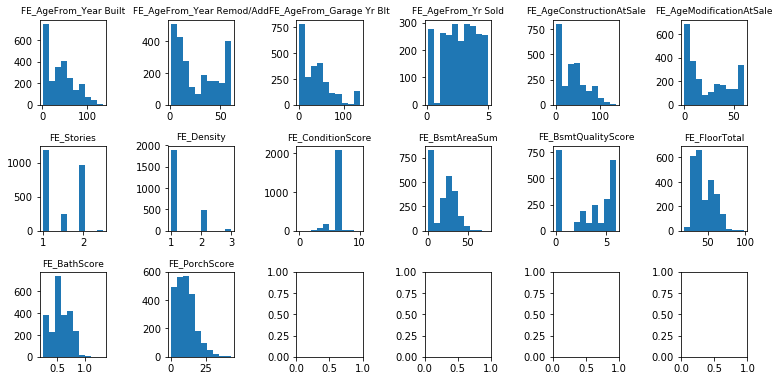

TRANSFORMATION: LOG10P1


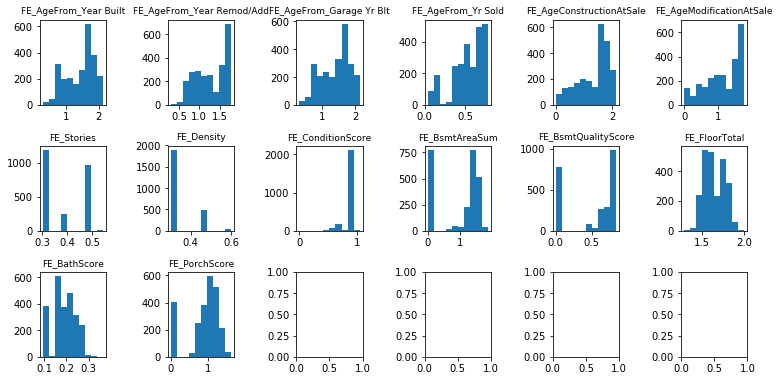

TRANSFORMATION: ROOT


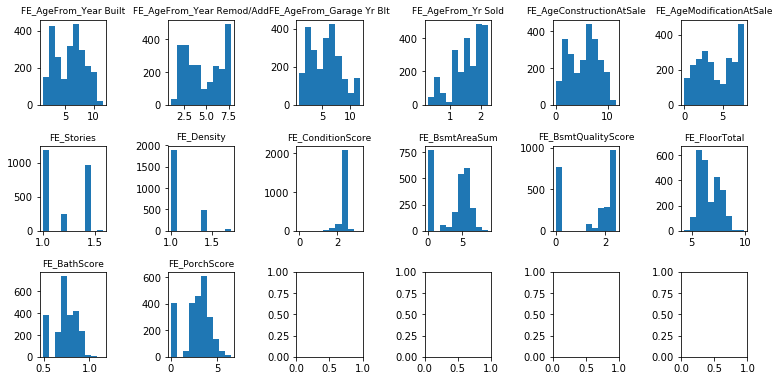

TRANSFORMATION: SQUARE


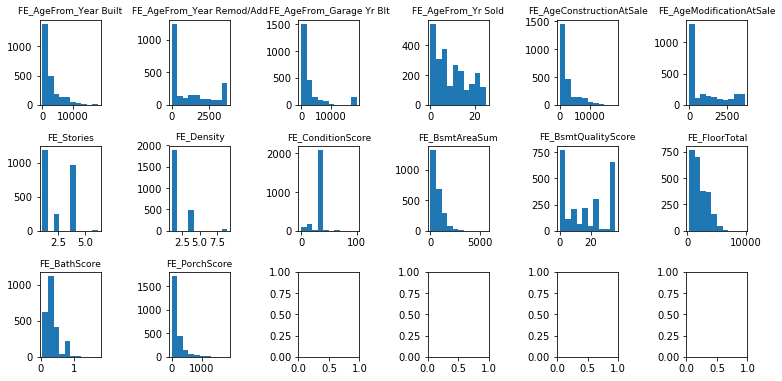

TRANSFORMATION: CUBE


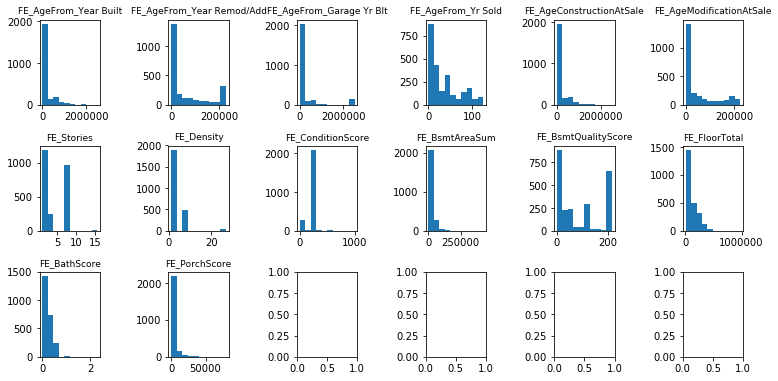

In [56]:
if gcblnShowDiagrams:
    # check distributions of newly engineered numeric features
    lstrTransformations = ["none", "log10p1", "root", "square","cube"] 
    for strTransformation in lstrTransformations:
        print("Transformation:".upper(), strTransformation.upper())
        SimpleDistributionPlots(ColumnsTransformed(dfrFETrain, lstrEngineeredNumeric, strTransformation), lstrEngineeredNumeric,10)

In [57]:
# define transformation for each engineered column, for later use
lstrEngineeredTransformations = []
lstrEngineeredLog10P1 = ["FE_FloorTotal"]
lstrEngineeredRoot = ["FE_AgeFrom_Year Built","FE_AgeFrom_Year Remod/Add","FE_AgeFrom_Garage Yr Blt",
                      "FE_AgeConstructionAtSale","FE_AgeModificationAtSale","FE_PorchScore"]
lstrEngineeredSquare = []
lstrEngineeredCube = []
for strEngineeredNumeric in lstrEngineeredNumeric:
    if strEngineeredNumeric in lstrEngineeredLog10P1:
        strTransformation = "log10p1"
    elif strEngineeredNumeric in lstrEngineeredRoot:
        strTransformation = "root"
    elif strEngineeredNumeric in lstrEngineeredSquare:
        strTransformation = "square"
    elif strEngineeredNumeric in lstrEngineeredCube:
        strTransformation = "cube"
    else:
        strTransformation = "none"
    lstrEngineeredTransformations.append(f"{strEngineeredNumeric}:{strTransformation}")

In [58]:
# apply transformations on engined features (FE)

# train
dfrFETrain = dfrCleanedTrain.copy()
dfrFETrain = ConvertYears(dfrFETrain, False)
dfrFETrain = IndividualFeatureEngineering(dfrFETrain, dfrFETrain.columns)
dfrFETrain = ColumnsTransformedIndividually (dfrFETrain, lstrEngineeredTransformations)

# test
dfrFETest = dfrCleanedTest.copy()
dfrFETest = ConvertYears(dfrFETest, False)
dfrFETest = IndividualFeatureEngineering(dfrFETest, dfrFETest.columns)
dfrFETest = ColumnsTransformedIndividually (dfrFETest, lstrEngineeredTransformations)

In [59]:
print("Increase of features:".upper())
print(f"Raw data columns: {len(dfrRawTrainData.columns)}")
print(f"Columns after FE: {len(dfrFETrain.columns)}")

INCREASE OF FEATURES:
Raw data columns: 82
Columns after FE: 119


## Model fitting

In [60]:
# dataframes for model fitting
dfrModelTrain = dfrFETrain.copy()
dfrModelTest = dfrFETest.copy()

Your analysis should include an appropriate baseline and evaluate three different models ranging in complexity
* A simple model with two variables (three with the target variable)
* An intermediate model (between 10 and 20 variables)
* A complex model with all variables

In [61]:
def MAE(y, y_pred):
    '''Calculates mean absolute error.'''
    # usually, the parameters are Numpy arrays
    # however, y_pred may be a single value
    return np.mean(np.abs(y - y_pred))

def MAEPercentage(y, y_pred):
    '''Calculates mean absolute proportional deviation.'''
    return np.mean(np.abs(1 - y_pred / y)) * 100

if False:
    afltPredictions = np.array([9,10,11])
    print(MAEPercentage(10,afltPredictions))

In [62]:
import locale
locale.setlocale(locale.LC_ALL, 'English')
def Rounded(fltNumber, intDigits=0):
    '''Applies American number format: single quote to separate 1000 and the period for decimals.'''
    strFormat = f"%.{intDigits}f"
    return locale.format(strFormat, fltNumber, True)

In [63]:
def PricesUSD(varSource):
    '''Back-transform prices from log scale (no unit) to normal scale in USD'''
    try:
        return 10**varSource.copy()["LogPrice"].values # dataframes
    except:
        return 10**varSource # numpy arrays or a single float

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
def BaselineModel(intSplitRepetitions, fltTestPortion):
    '''Use the median as a (very) rough estimate for the sale price.'''
    
    # init
    ldblMedians = []
    ldblMae = []
    ldblMaePercentage = []
    
    # apply model on each split
    for intSplitRepetition in range(intSplitRepetitions):
        
        # split
        dfrSplitTrain, dfrSplitValidation = train_test_split(dfrModelTrain, test_size=fltTestPortion)
        
        # model
        dblMedian = np.median(dfrSplitTrain["LogPrice"])
        dblMedianUSD = PricesUSD(dblMedian)
        
        # remember
        ldblMedians.append(dblMedianUSD)
        afltActualPrices = PricesUSD(dfrSplitValidation)
        ldblMae.append(MAE(afltActualPrices,dblMedianUSD))
        ldblMaePercentage.append(MAEPercentage(afltActualPrices,dblMedianUSD))
        
    # evaluate
    dblMeanMedians = np.mean(ldblMedians)
    dblStdMedians = np.std(ldblMedians)
    dblMeanMae = np.mean(ldblMae)
    dblStdMae = np.std(ldblMae)
    dblMeanMaePercentage = np.mean(ldblMaePercentage)
    dblStdMaePercentage = np.std(ldblMaePercentage)
    
    # feedback
    print(f'Mean median: {Rounded(dblMeanMedians)}$ ± {Rounded(dblStdMedians)}$')
    print(f'Mean MAE: {Rounded(dblMeanMae)}$ ± {Rounded(dblStdMae)}$')
    print(f'Mean MAE percentage: {Rounded(dblMeanMaePercentage,1)}% ± {Rounded(dblStdMaePercentage,1)}%')
    return dblMeanMae, dblMeanMaePercentage

In [66]:
def ClipNegative(afltSource):
    '''Sets negative values to 0.'''
    return afltSource.clip(0)

In [67]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor # SGD = Stochastic Gradient Descent
from sklearn.preprocessing import StandardScaler

def StochasticGradientDescent (intSplitRepetitions, fltTestPortion, lstrFeatures, strModel):
    
    # init
    ldblMae = []
    ldblMaePercentage = []
    cfltTypicalGoodEpsilon = 1.35
    intSgdIterations = 1e5
    strMethod = "squared_loss"
    
    dfrOutput = pd.DataFrame(dfrModelTest["PID"])
    
    # apply model on each split
    for intSplitRepetition in range(intSplitRepetitions):
        
        # split
        dfrSplitTrain, dfrSplitValidation = train_test_split(dfrModelTrain, test_size=fltTestPortion)
        
        # create a linear regression object
        lrgLinearRegressionObject = LinearRegression()

        # create X (features) and y (target)
        # tr=train, va=validation
        X_tr = dfrSplitTrain[lstrFeatures].values
        y_tr = dfrSplitTrain["LogPrice"].values
        X_va = dfrSplitValidation[lstrFeatures].values
        y_va = dfrSplitValidation["LogPrice"].values
        X_te = dfrModelTest[lstrFeatures].values

        # scale features as they have different distributions 
        objStandardScaler = StandardScaler()
        X_tr_scaled = objStandardScaler.fit_transform(X_tr)
        X_va_scaled = objStandardScaler.transform(X_va)
        X_te_scaled = objStandardScaler.transform(X_te)
        
        # calculate regression
        objSgdRegressor = SGDRegressor(loss=strMethod, penalty='none', 
                                       epsilon=cfltTypicalGoodEpsilon, 
                                       max_iter=intSgdIterations, 
                                       tol=1e-6)    
        objSgdRegressor.fit(X_tr_scaled, y_tr)

        # predict within validation set
        y_va_pred = objSgdRegressor.predict(X_va_scaled) 
        y_te_pred = objSgdRegressor.predict(X_te_scaled) 

        # finalising predictions
        afltPredictionsStreamlined = PricesUSD(y_va_pred)
        afltPredictionsStreamlined = ClipNegative(afltPredictionsStreamlined)
        afltPredictionsStreamlinedTest = PricesUSD(y_te_pred)
        afltPredictionsStreamlinedTest = ClipNegative(afltPredictionsStreamlinedTest)

        dfrOutput[f"SP{intSplitRepetition}"] = afltPredictionsStreamlinedTest
    
        # calculate the validation MAE 
        afltActualPrices = PricesUSD(y_va)
        fltMae           = MAE          (afltActualPrices, afltPredictionsStreamlined)
        fltMaePercentage = MAEPercentage(afltActualPrices, afltPredictionsStreamlined)
       
        #remember
        ldblMae.append(fltMae)
        ldblMaePercentage.append(fltMaePercentage)
    
    dfrOutput['SalePrice'] = dfrOutput.iloc[:,1:].mean(axis=1)
    dfrOutput = dfrOutput[["PID",'SalePrice']]
    strFilename = f"predictions-{strModel}-model.csv"
    dfrOutput.to_csv(strFilename, index=False)
    
    # evaluate
    dblMeanMae = np.mean(ldblMae)
    dblStdMae = np.std(ldblMae)
    dblMeanMaePercentage = np.mean(ldblMaePercentage)
    dblStdMaePercentage = np.std(ldblMaePercentage)
    
    # feedback
    print(f'Mean MAE: {Rounded(dblMeanMae)}$ ± {Rounded(dblStdMae)}$')
    print(f'Mean MAE percentage: {Rounded(dblMeanMaePercentage,1)}% ± {Rounded(dblStdMaePercentage,1)}%')
    return dblMeanMae, dblMeanMaePercentage

In [68]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def RidgeRegression (intSplitRepetitions, fltTestPortion, lstrFeatures, fltAlpha):
    
    # init
    ldblMae = []    
    ldblMaePercentage = []    
    dfrOutput = pd.DataFrame(dfrModelTest["PID"])  
    
    # apply model on each split
    for intSplitRepetition in range(intSplitRepetitions):
 
        # split
        dfrSplitTrain, dfrSplitValidation = train_test_split(dfrModelTrain, test_size=fltTestPortion)

        # create X (features) and y (target)
        # tr=train, va=validation
        X_tr = dfrSplitTrain[lstrFeatures].values
        y_tr = dfrSplitTrain["LogPrice"].values
        X_va = dfrSplitValidation[lstrFeatures].values
        y_va = dfrSplitValidation["LogPrice"].values
        X_te = dfrModelTest[lstrFeatures].values

        # scale features as they have different distributions 
        objStandardScaler = StandardScaler()
        X_tr_scaled = objStandardScaler.fit_transform(X_tr)
        X_va_scaled = objStandardScaler.transform(X_va)
        X_te_scaled = objStandardScaler.transform(X_te)
        
        # create a linear regression object
        objRidge = Ridge(alpha=fltAlpha)
        objRidge.fit(X_tr_scaled, y_tr)
        y_va_pred = objRidge.predict(X_va_scaled)
        y_te_pred = objRidge.predict(X_te_scaled)
        
        
        # finalising predictions
        afltPredictionsStreamlined = PricesUSD(y_va_pred)
        afltPredictionsStreamlined = ClipNegative(afltPredictionsStreamlined)
        
        afltPredictionsStreamlinedTest = PricesUSD(y_te_pred)
        afltPredictionsStreamlinedTest = ClipNegative(afltPredictionsStreamlinedTest)
        
        dfrOutput[f"SP{intSplitRepetition}"] = afltPredictionsStreamlinedTest ### PROBLEM!
        
        # calculate the validation MAE 
        afltTruePrices = PricesUSD(y_va)
        fltMae           = MAE          (afltTruePrices, afltPredictionsStreamlined)
        fltMaePercentage = MAEPercentage(afltTruePrices, afltPredictionsStreamlined)
        
        # remember
        ldblMae.append(fltMae)
        ldblMaePercentage.append(fltMaePercentage)
    
    cdblBestAlpha = 10 # defined by grid-search
    if fltAlpha == cdblBestAlpha:
        dfrOutput['SalePrice'] = dfrOutput.iloc[:,1:].mean(axis=1)
        dfrOutput = dfrOutput[["PID",'SalePrice']]
        strFilename = f"predictions-{strModel}-model.csv"
        dfrOutput.to_csv(strFilename, index=False)
    
    # evaluate
    dblMeanMae = np.mean(ldblMae)
    dblStdMae = np.std(ldblMae)
    dblMeanMaePercentage = np.mean(ldblMaePercentage)
    dblStdMaePercentage  = np.std(ldblMaePercentage)    
             
    # feedback
    print(f'Mean MAE with α={Rounded(fltAlpha,4)}: {Rounded(dblMeanMae)}$ ± {Rounded(dblStdMae)}$')
    
    # playback result for further use in diagram
    lfltMaeRange = [dblMeanMae-dblStdMae,dblMeanMae,dblMeanMae+dblStdMae]
    return lfltMaeRange, dblMeanMaePercentage, dblStdMaePercentage

In [69]:
# define and apply different models
strBaselineModel, strSimpleModel, strIntermediateModel, strComplexModel = \
    "baseline","simple","intermediate", "complex"

lstrSimpleFeatures = ["Lot Area","Gr Liv Area"]
lstrIntermediateFeatures = [
    "Lot Area","Gr Liv Area","FE_AgeConstructionAtSale","FE_AgeModificationAtSale",
    "FE_AfterCrash2008","FE_IsLowDensity","FE_ConditionScore","FE_IsPostWar","FE_HasAsbestos",
    "FE_BsmtAreaSum","FE_BsmtQualityScore","FE_HasSecondFloor",
    "FE_BathScore","FE_HasFireplaces","FE_HasGarage","FE_PorchScore","FE_HasPool","FE_IsFamilySale"
]
lstrComplexFeatures = dfrModelTrain.select_dtypes(include=np.number).columns.tolist()
lstrComplexFeatures.remove("LogPrice") # target
lstrComplexFeatures.remove("SalePrice") # target
lstrComplexFeatures.remove("PID") # PID is meaningless

dlvarModels = {
    strBaselineModel:{"method":"median", "features":[]},
    strSimpleModel:{"method":"linear", "features":lstrSimpleFeatures},
    strIntermediateModel:{"method":"linear", "features":lstrIntermediateFeatures},
    strComplexModel:{"method":"ridge", "features":lstrComplexFeatures}
}
lstrModels = dlvarModels.keys()
intSplitRepetitions = 50
intAlphaSteps = 30
fltTestPortion = 0.2
fltTestPortionPercent = fltTestPortion * 100
lfltAlphas = np.logspace(-4,4,intAlphaSteps)
cfltBestAlpha = 10 # defined by grid search
lfltAlphas = np.append(lfltAlphas,cfltBestAlpha) # make sure the best alpha is included

lfltModelMae = []
lfltModelMaePercentage = []

print("MODELS")
print("------\n")
print("GENERAL:")
print(f"Split repetitions: {intSplitRepetitions}")
print(f"Alpha steps: {intAlphaSteps}")
print(f"Train/validation split: {Rounded(100-fltTestPortionPercent)}:{Rounded(fltTestPortionPercent)}")
for strModel in lstrModels:
    
    # init
    strMethod = dlvarModels[strModel]["method"]
    lstrFeatures = dlvarModels[strModel]["features"]
    intFeatures = len(lstrFeatures)
    lftlMaeLow = []
    lftlMaeMean = []
    lftlMaeHigh = []
    
    print(f"\n{strModel} model".upper())
    print(f"Method: {strMethod}")
    print(f"Features: {intFeatures}")   
    
    if strModel in [strBaselineModel]:
        fltMeanMae,fltMeanMaePercentage = BaselineModel(intSplitRepetitions,fltTestPortion)
        lfltModelMae.append(fltMeanMae)
        lfltModelMaePercentage.append(fltMeanMaePercentage)
    elif strModel in [strSimpleModel,strIntermediateModel]:
        fltMeanMae,fltMeanMaePercentage = StochasticGradientDescent(intSplitRepetitions,fltTestPortion,lstrFeatures,strModel)
        lfltModelMae.append(fltMeanMae)
        lfltModelMaePercentage.append(fltMeanMaePercentage)
    elif strModel in [strComplexModel]:
        fltBestMae = -1
        fltBestAlpha = -1
        for fltAlpha in lfltAlphas:
            lfltMaeRange, fltMeanMaePercentage, fltStdMaePercentage = RidgeRegression(intSplitRepetitions,fltTestPortion,lstrFeatures,fltAlpha)
            fltLow, fltMean, fltHigh = lfltMaeRange
            lftlMaeLow.append(fltLow)
            lftlMaeMean.append(fltMean)
            lftlMaeHigh.append(fltHigh)
            if fltBestMae < 0 or fltBestMae > fltMean:
                fltBestMae = fltMean
                fltBestAlpha = fltAlpha
                fltBestStd = fltMean - fltLow
                fltBestMeanMaePercentage = fltMeanMaePercentage
                fltBestStdMaePercentage = fltStdMaePercentage
        lfltModelMae.append(fltBestMae)
        lfltModelMaePercentage.append(fltBestMeanMaePercentage)
        print(f"\nResult for α = {cfltBestAlpha}:")
        print(f'Mean MAE: {Rounded(fltBestMae)}$ ± {Rounded(fltBestStd)}$')
        print(f'Mean MAE percentage: {Rounded(fltBestMeanMaePercentage,1)}% ± {Rounded(fltBestStdMaePercentage,1)}%')
    else:
        print(f"Model {strModel} not done yet.")
        

MODELS
------

GENERAL:
Split repetitions: 50
Alpha steps: 30
Train/validation split: 80:20

BASELINE MODEL
Method: median
Features: 0
Mean median: 160,444$ ± 945$
Mean MAE: 56,276$ ± 2,839$
Mean MAE percentage: 32.5% ± 1.6%

SIMPLE MODEL
Method: linear
Features: 2
Mean MAE: 38,290$ ± 1,668$
Mean MAE percentage: 22.6% ± 1.4%

INTERMEDIATE MODEL
Method: linear
Features: 18
Mean MAE: 21,617$ ± 1,105$
Mean MAE percentage: 12.7% ± 0.9%

COMPLEX MODEL
Method: ridge
Features: 94
Mean MAE with α=0.0001: 15,485$ ± 1,006$
Mean MAE with α=0.0002: 15,491$ ± 1,271$
Mean MAE with α=0.0004: 15,359$ ± 1,377$
Mean MAE with α=0.0007: 15,461$ ± 1,220$
Mean MAE with α=0.0013: 15,894$ ± 1,277$
Mean MAE with α=0.0024: 15,410$ ± 1,227$
Mean MAE with α=0.0045: 15,889$ ± 1,375$
Mean MAE with α=0.0085: 15,605$ ± 1,174$
Mean MAE with α=0.0161: 15,097$ ± 1,173$
Mean MAE with α=0.0304: 15,458$ ± 1,179$
Mean MAE with α=0.0574: 15,393$ ± 1,065$
Mean MAE with α=0.1083: 15,679$ ± 965$
Mean MAE with α=0.2043: 15,422$ 

In [70]:
def RemoveLastElement(avarSource):
    '''Removes last element from Numpy array.'''
    return avarSource[np.arange(avarSource.size - 1)]


With this trial (50 repetitions), α = 0.3857 yields the lowest MAE, i.e. 15,050$.



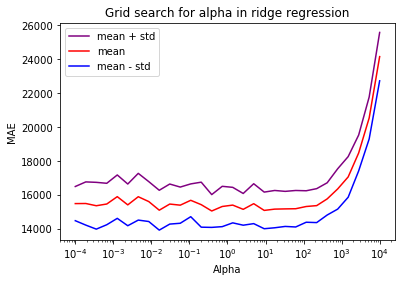

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# remove best ridge element
lfltAlphas = RemoveLastElement(lfltAlphas)
lftlMaeHigh.pop()
lftlMaeMean.pop()
lftlMaeLow.pop()

# plot grid search for alpha
fig = plt.figure()
ax = plt.gca()
ax.plot(lfltAlphas, lftlMaeHigh , c='purple', label="mean + std")
ax.plot(lfltAlphas, lftlMaeMean , c='red', label="mean")
ax.plot(lfltAlphas, lftlMaeLow , c='blue', label="mean - std")
ax.set_xscale('log')
plt.title("Grid search for alpha in ridge regression")
plt.xlabel("Alpha")
plt.ylabel("MAE")
leg = ax.legend()
plt.show; 

print(f"\nWith this trial ({intSplitRepetitions} repetitions), α = {Rounded(fltBestAlpha,4)} yields the lowest MAE,", \
      f"i.e. {Rounded(fltBestMae)}$.\n")

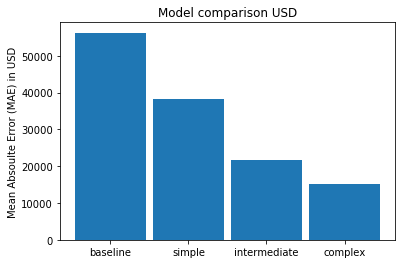

In [72]:
fltBarWidth = 0.9
plt.bar(lstrModels, lfltModelMae, fltBarWidth)
plt.ylabel("Mean Absoulte Error (MAE) in USD")
plt.title("Model comparison USD")
plt.show()

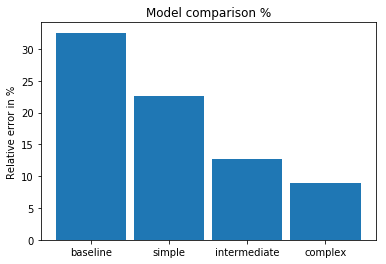

In [73]:
fltBarWidth = 0.9
plt.bar(lstrModels, lfltModelMaePercentage, fltBarWidth)
plt.ylabel("Relative error in %")
plt.title("Model comparison %")
plt.show()

__Remarks:__
* The feature `FE_HasElevator` has a very negative impact on the intermediate model, therefore this engineered feature has been dropped. Reason: there is only 1 sale with an elevator. 
* For the complex model (i.e. all numeric features), the SGD approach would yield a MAE with an order of magnitude around `1e100`.
* Durint ridge regression, α values between 1 and 100 yield the best results for MAE, when applying up to 100 train/validiation splits. I choose __α = 10__ to define the complex model.
* This choice of α is __somewhat arbitrary__, but other α values from 1 to 9 would yield similar results.
* There is a __clear improvement__ of the model: baseline < simple < intermediate < complex.
* I expected __relative deviations__ (%) being better than __normal deviations__ (MAE in USD), as sale prices cover quite a large range, and a deviation of 15K is expected to be much different for sales around 50K vs. sales around 500K. But actually the result is more or less the same.

## Predictions on test data

__CSV upload:__
* URL: __p3review.herokuapp.com__ 
* Result see below.
* Comparison valdiation vs. test:
    * SIMPLE: 38,632 vs 37,707 
    * INTERMEDIATE: 20,954 vs 20,728
    * COMPLEX: 13,966 vs. 14,836
* Conclusion: the test data yield __similar MAE__ as the ones obtained by validation.

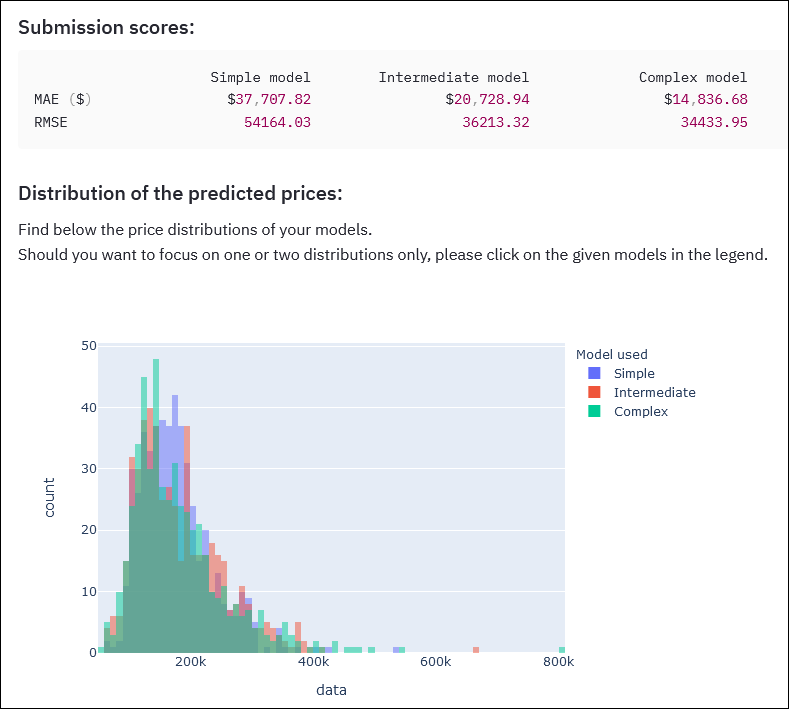